In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=8)
palette

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

# Lotka-Volterra equations (Cycle model)

\begin{align}
\dot X_1 &= a_0 X_1 - a_1 X_1 - a_2 X_1 X_2 + a_3 X_1 X_3 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 - a_6 X_2 X_3 \\
\dot X_3 &= -a_7 X_1 X_3 + a_8 X_2 X_3 - a_9 X_3 \\
\end{align}

In [3]:
def modelLV(Y, t, a0, a1, a2, a3, a4, a5, a6, a7, a8, a9):
    X1, X2, X3 = Y
    
    dX1 = a0*X1 - a1*X1 - a2*X1*X2 + a3*X1*X3
    dX2 = a4*X1*X2 - a5*X2 - a6*X2*X3
    dX3 = -a7*X1*X3 + a8*X2*X3 - a9*X3
    
    return [dX1, dX2, dX3]

In [4]:
a0 = 0.0 # Reproduction rate of X1
a1 = 0.18 # Mortality rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = 0.15 # Reproduction rate of X1 in presence of X3
a4 = 0.11 # Reproduction rate of X2 in presence of X1
a5 = 0.02 # Mortality rate of X2
a6 = 0.12 # Rate of predation of X3 on X2
a7 = 0.04 # Rate of predation of X1 on X3
a8 = 0.12 # Reproduction rate of X3 in presence of X2
a9 = 0.02 # Mortality rate of X3

In [5]:
names=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']

In [6]:
dfGroundPars = pd.DataFrame([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9]).T
dfGroundPars.columns = names

In [7]:
dfGroundPars

a0    a1    a2    a3    a4    a5    a6    a7    a8    a9
0  0.0  0.18  0.16  0.15  0.11  0.02  0.12  0.04  0.12  0.02

# Generating data

In [29]:
a0 = dfGroundPars['a0'][0]
a1 = dfGroundPars['a1'][0]
a2 = dfGroundPars['a2'][0]
a3 = dfGroundPars['a3'][0]
a4 = dfGroundPars['a4'][0]
a5 = dfGroundPars['a5'][0]
a6 = dfGroundPars['a6'][0]
a7 = dfGroundPars['a7'][0]
a8 = dfGroundPars['a8'][0]
a9 = dfGroundPars['a9'][0]

In [30]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

In [31]:
sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))

In [32]:
X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

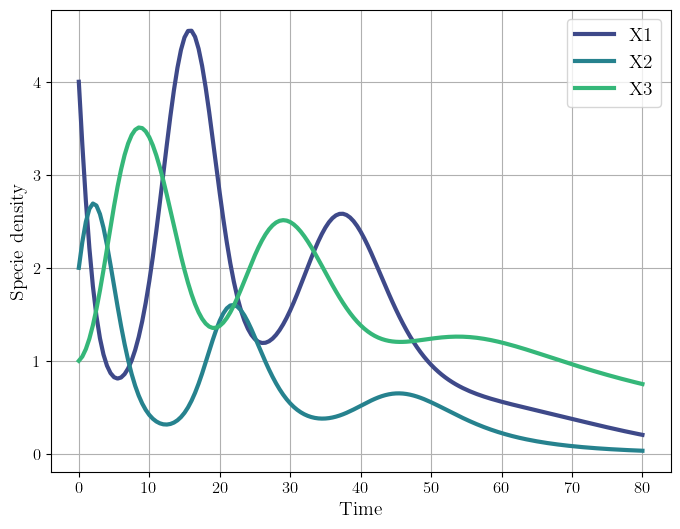

In [33]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X1_g, lw=3, color=palette[1], label='X1')
axs.plot(t, X2_g, lw=3, color=palette[3], label='X2')
axs.plot(t, X3_g, lw=3, color=palette[5], label='X3')
axs.legend(loc='best')
axs.set_xlabel('Time')
axs.set_ylabel('Specie density')
axs.grid()

plt.show()

# Recovering parameters

In [62]:
dfParams_ground = dfGroundPars.drop(columns=['a0']).melt(var_name='Parameters', value_name='Values')

In [63]:
parNames=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'RMSE']

In [64]:
dfData = pd.read_csv('cycle/LVdata_noise.data', sep=' ')

## Quantitative X1

In [65]:
dfParams = pd.read_csv('cycle/bestPars_quant.dat', sep=' ', names=parNames)

In [66]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

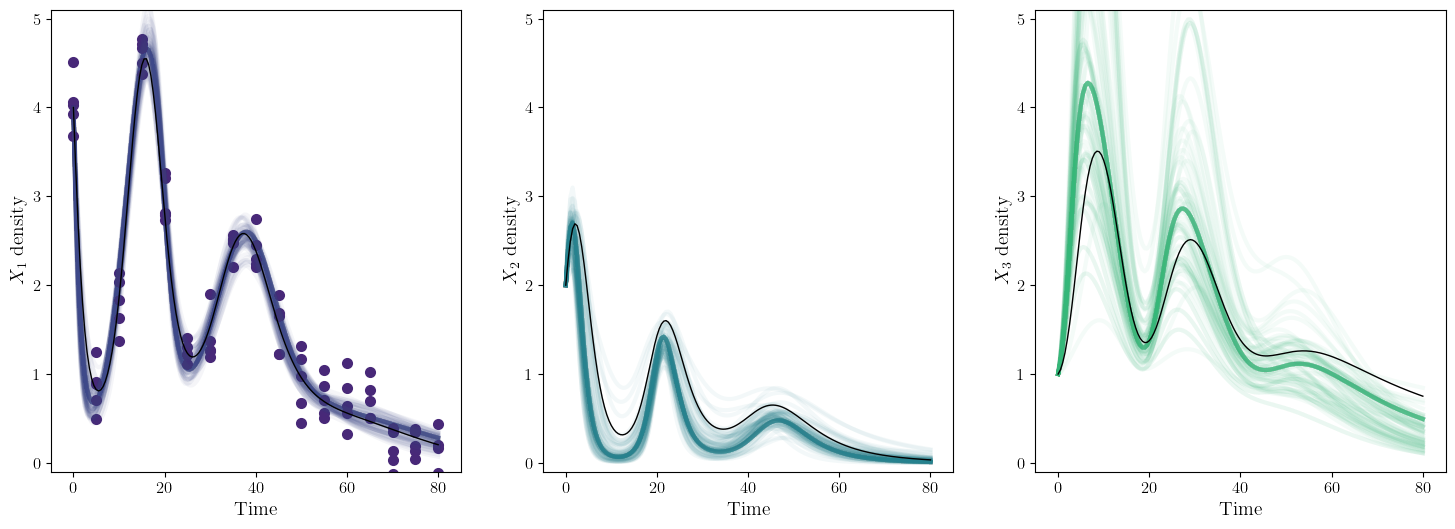

In [67]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [68]:
dfParams_quant = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

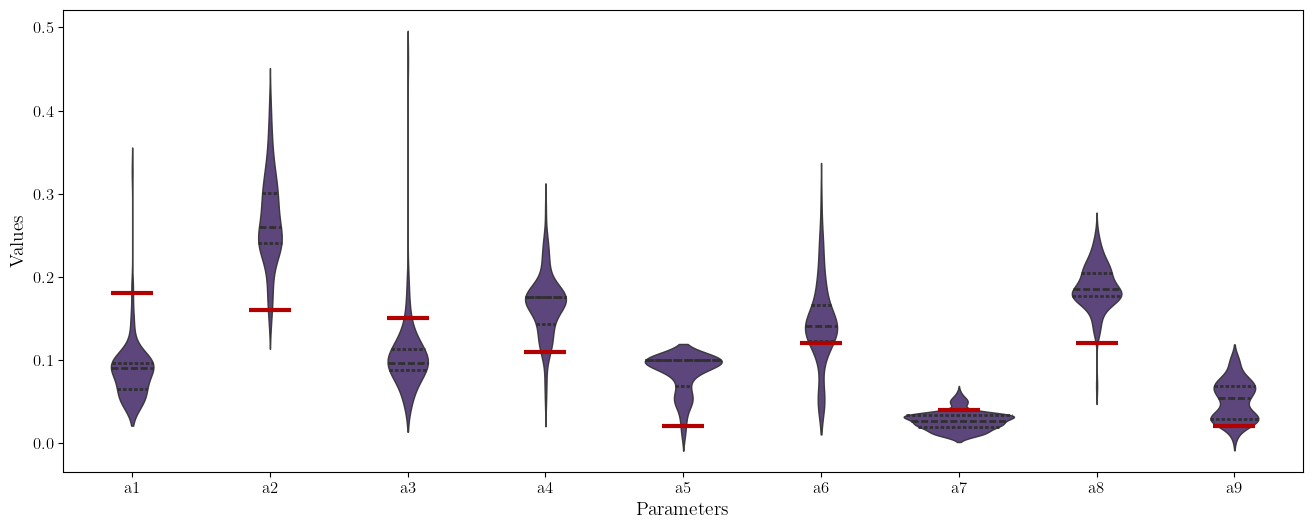

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_quant, x='Parameters', y='Values',
               color=palette[0], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

### Likelihood profiles

In [101]:
df_a1 = pd.read_csv('cycle/a1Profile.dat', sep=' ', names=parNames).filter(['a1', 'RMSE'])
df_a2 = pd.read_csv('cycle/a2Profile.dat', sep=' ', names=parNames).filter(['a2', 'RMSE'])
df_a3 = pd.read_csv('cycle/a3Profile.dat', sep=' ', names=parNames).filter(['a3', 'RMSE'])
df_a4 = pd.read_csv('cycle/a4Profile.dat', sep=' ', names=parNames).filter(['a4', 'RMSE'])
df_a5 = pd.read_csv('cycle/a5Profile.dat', sep=' ', names=parNames).filter(['a5', 'RMSE'])
df_a6 = pd.read_csv('cycle/a6Profile.dat', sep=' ', names=parNames).filter(['a6', 'RMSE'])
df_a7 = pd.read_csv('cycle/a7Profile.dat', sep=' ', names=parNames).filter(['a7', 'RMSE'])
df_a8 = pd.read_csv('cycle/a8Profile.dat', sep=' ', names=parNames).filter(['a8', 'RMSE'])
df_a9 = pd.read_csv('cycle/a9Profile.dat', sep=' ', names=parNames).filter(['a9', 'RMSE'])

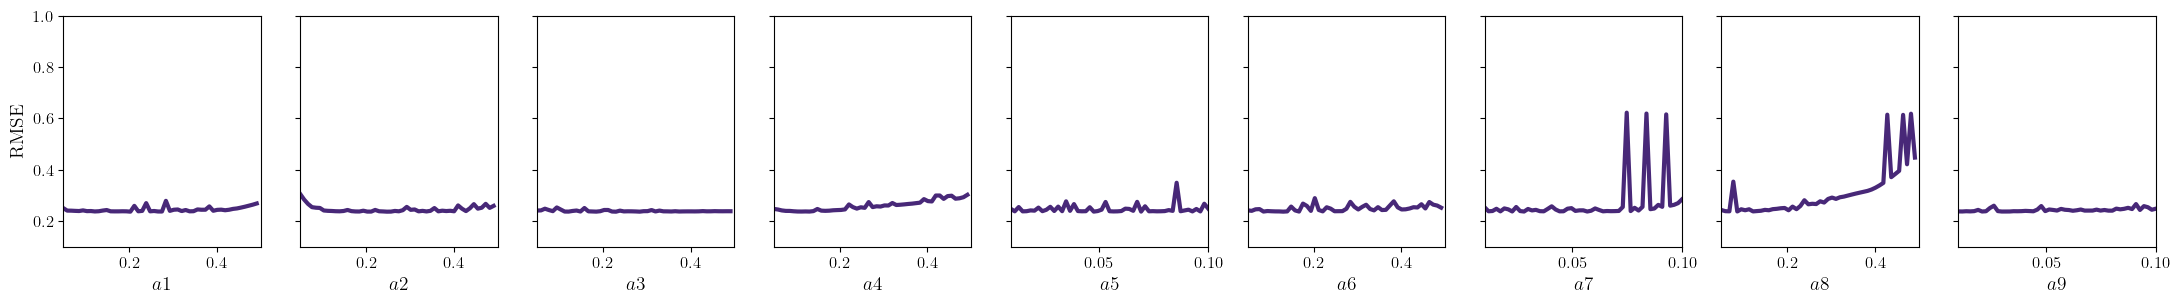

In [102]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(27,3), sharey=True, facecolor='white')

axs[0].plot(df_a1['a1'], df_a1['RMSE'], lw=3, color=palette[0])
axs[0].set_xlabel('$a1$')
axs[0].set_ylabel('RMSE')
axs[0].set_xlim((0.05,0.5))

axs[1].plot(df_a2['a2'], df_a2['RMSE'], lw=3, color=palette[0])
axs[1].set_xlabel('$a2$')
axs[1].set_xlim((0.05,0.5))

axs[2].plot(df_a3['a3'], df_a3['RMSE'], lw=3, color=palette[0])
axs[2].set_xlabel('$a3$')
axs[2].set_xlim((0.05,0.5))

axs[3].plot(df_a4['a4'], df_a4['RMSE'], lw=3, color=palette[0])
axs[3].set_xlabel('$a4$')
axs[3].set_xlim((0.05,0.5))

axs[4].plot(df_a5['a5'], df_a5['RMSE'], lw=3, color=palette[0])
axs[4].set_xlabel('$a5$')
axs[4].set_xlim((0.01,0.1))

axs[5].plot(df_a6['a6'], df_a6['RMSE'], lw=3, color=palette[0])
axs[5].set_xlabel('$a6$')
axs[5].set_xlim((0.05,0.5))

axs[6].plot(df_a7['a7'], df_a7['RMSE'], lw=3, color=palette[0])
axs[6].set_xlabel('$a7$')
axs[6].set_xlim((0.01,0.1))

axs[7].plot(df_a8['a8'], df_a8['RMSE'], lw=3, color=palette[0])
axs[7].set_xlabel('$a8$')
axs[7].set_xlim((0.05,0.5))

axs[8].plot(df_a9['a9'], df_a9['RMSE'], lw=3, color=palette[0])
axs[8].set_xlabel('$a9$')
axs[8].set_xlim((0.01,0.1))

plt.setp(axs, ylim=(0.1,1.0))

plt.show()

In [103]:
df_a1_quant = df_a1
df_a2_quant = df_a2
df_a3_quant = df_a3
df_a4_quant = df_a4
df_a5_quant = df_a5
df_a6_quant = df_a6
df_a7_quant = df_a7
df_a8_quant = df_a8
df_a9_quant = df_a9

## Qualitative X2

In [70]:
dfQual_x2 = pd.read_csv('cycle/LVdata_qual_x2.data', sep=' ')

In [71]:
dfParams = pd.read_csv('cycle/bestPars_x2.dat', sep=' ', names=parNames)

In [72]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

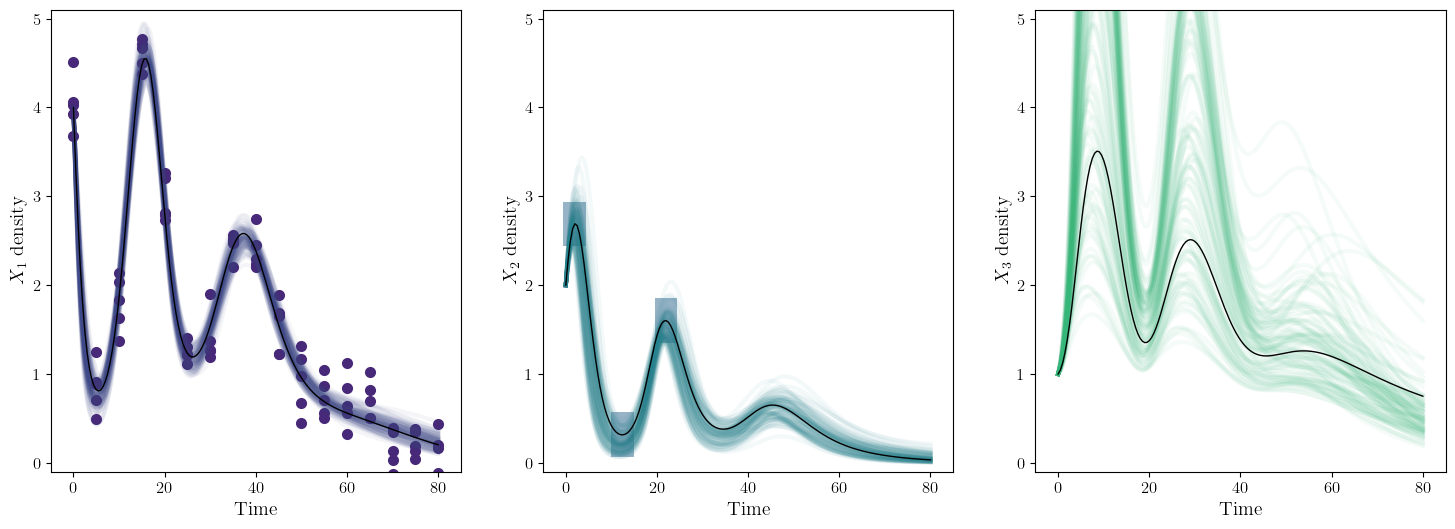

In [73]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [74]:
dfParams_x2 = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

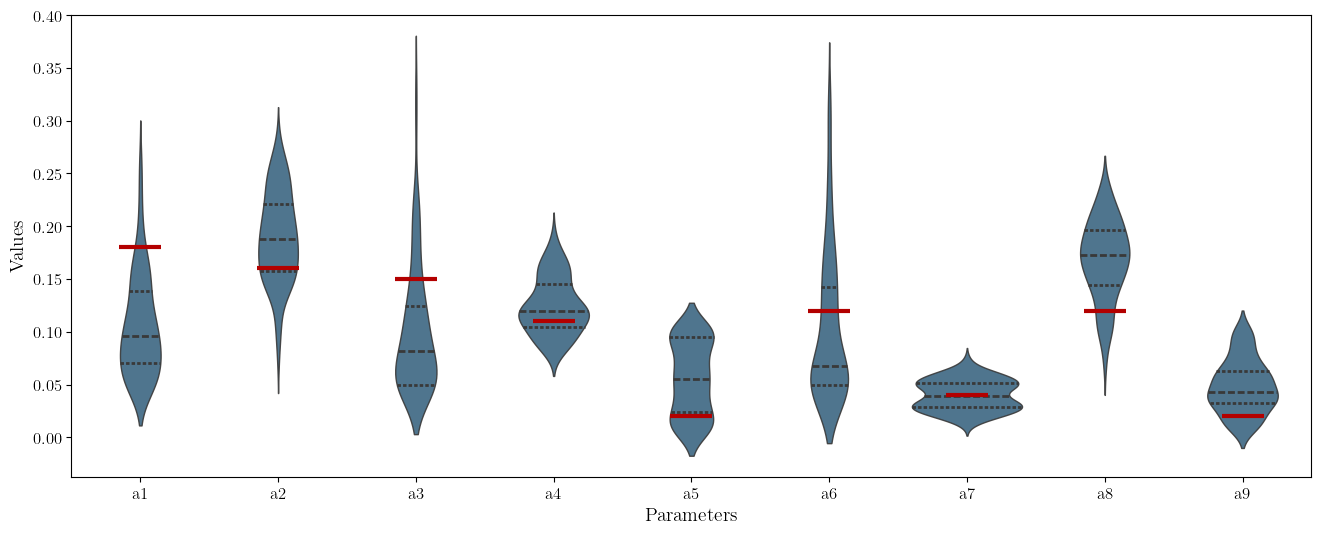

In [75]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x2, x='Parameters', y='Values',
               color=palette[2], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

### Likelihood profiles

In [110]:
df_a1 = pd.read_csv('cycle/a1Profile_x2.dat', sep=' ', names=parNames).filter(['a1', 'RMSE'])
df_a2 = pd.read_csv('cycle/a2Profile_x2.dat', sep=' ', names=parNames).filter(['a2', 'RMSE'])
df_a3 = pd.read_csv('cycle/a3Profile_x2.dat', sep=' ', names=parNames).filter(['a3', 'RMSE'])
df_a4 = pd.read_csv('cycle/a4Profile_x2.dat', sep=' ', names=parNames).filter(['a4', 'RMSE'])
df_a5 = pd.read_csv('cycle/a5Profile_x2.dat', sep=' ', names=parNames).filter(['a5', 'RMSE'])
df_a6 = pd.read_csv('cycle/a6Profile_x2.dat', sep=' ', names=parNames).filter(['a6', 'RMSE'])
df_a7 = pd.read_csv('cycle/a7Profile_x2.dat', sep=' ', names=parNames).filter(['a7', 'RMSE'])
df_a8 = pd.read_csv('cycle/a8Profile_x2.dat', sep=' ', names=parNames).filter(['a8', 'RMSE'])
df_a9 = pd.read_csv('cycle/a9Profile_x2.dat', sep=' ', names=parNames).filter(['a9', 'RMSE'])

In [111]:
df_a1 = df_a1[df_a1['RMSE'] != 1e10]
df_a2 = df_a2[df_a2['RMSE'] != 1e10]
df_a3 = df_a3[df_a3['RMSE'] != 1e10]
df_a4 = df_a4[df_a4['RMSE'] != 1e10]
df_a5 = df_a5[df_a5['RMSE'] != 1e10]
df_a6 = df_a6[df_a6['RMSE'] != 1e10]
df_a7 = df_a7[df_a7['RMSE'] != 1e10]
df_a8 = df_a8[df_a8['RMSE'] != 1e10]
df_a9 = df_a9[df_a9['RMSE'] != 1e10]

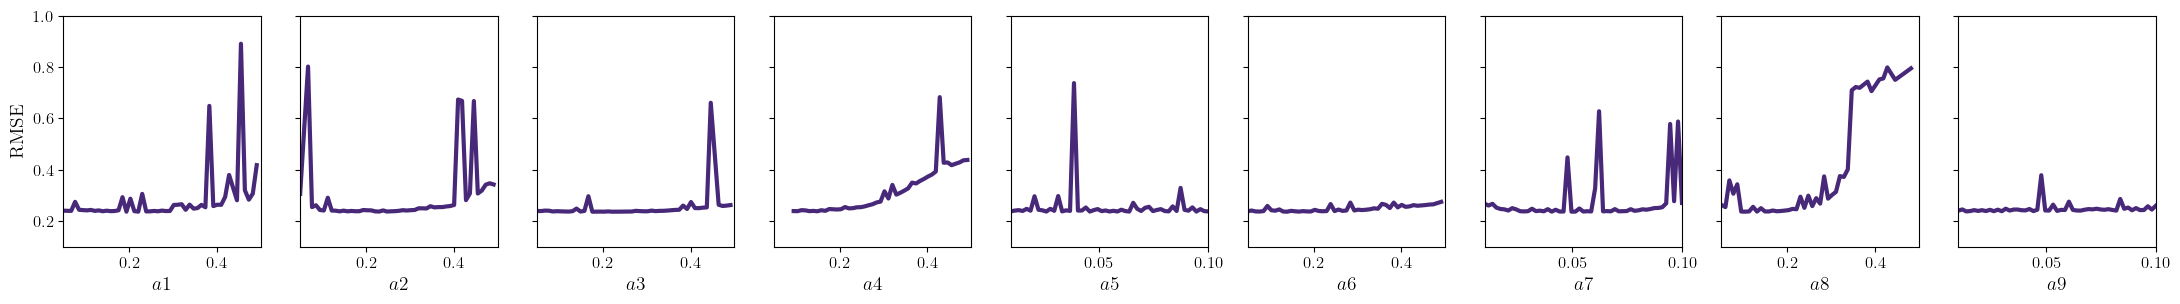

In [112]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(27,3), sharey=True, facecolor='white')

axs[0].plot(df_a1['a1'], df_a1['RMSE'], lw=3, color=palette[0])
axs[0].set_xlabel('$a1$')
axs[0].set_ylabel('RMSE')
axs[0].set_xlim((0.05,0.5))

axs[1].plot(df_a2['a2'], df_a2['RMSE'], lw=3, color=palette[0])
axs[1].set_xlabel('$a2$')
axs[1].set_xlim((0.05,0.5))

axs[2].plot(df_a3['a3'], df_a3['RMSE'], lw=3, color=palette[0])
axs[2].set_xlabel('$a3$')
axs[2].set_xlim((0.05,0.5))

axs[3].plot(df_a4['a4'], df_a4['RMSE'], lw=3, color=palette[0])
axs[3].set_xlabel('$a4$')
axs[3].set_xlim((0.05,0.5))

axs[4].plot(df_a5['a5'], df_a5['RMSE'], lw=3, color=palette[0])
axs[4].set_xlabel('$a5$')
axs[4].set_xlim((0.01,0.1))

axs[5].plot(df_a6['a6'], df_a6['RMSE'], lw=3, color=palette[0])
axs[5].set_xlabel('$a6$')
axs[5].set_xlim((0.05,0.5))

axs[6].plot(df_a7['a7'], df_a7['RMSE'], lw=3, color=palette[0])
axs[6].set_xlabel('$a7$')
axs[6].set_xlim((0.01,0.1))

axs[7].plot(df_a8['a8'], df_a8['RMSE'], lw=3, color=palette[0])
axs[7].set_xlabel('$a8$')
axs[7].set_xlim((0.05,0.5))

axs[8].plot(df_a9['a9'], df_a9['RMSE'], lw=3, color=palette[0])
axs[8].set_xlabel('$a9$')
axs[8].set_xlim((0.01,0.1))

plt.setp(axs, ylim=(0.1,1.0))

plt.show()

In [113]:
df_a1_x2 = df_a1
df_a2_x2 = df_a2
df_a3_x2 = df_a3
df_a4_x2 = df_a4
df_a5_x2 = df_a5
df_a6_x2 = df_a6
df_a7_x2 = df_a7
df_a8_x2 = df_a8
df_a9_x2 = df_a9

## Qualitative X3

In [76]:
dfQual_x3 = pd.read_csv('cycle/LVdata_qual_x3.data', sep=' ')

In [77]:
dfParams = pd.read_csv('cycle/bestPars_x3.dat', sep=' ', names=parNames)

In [78]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

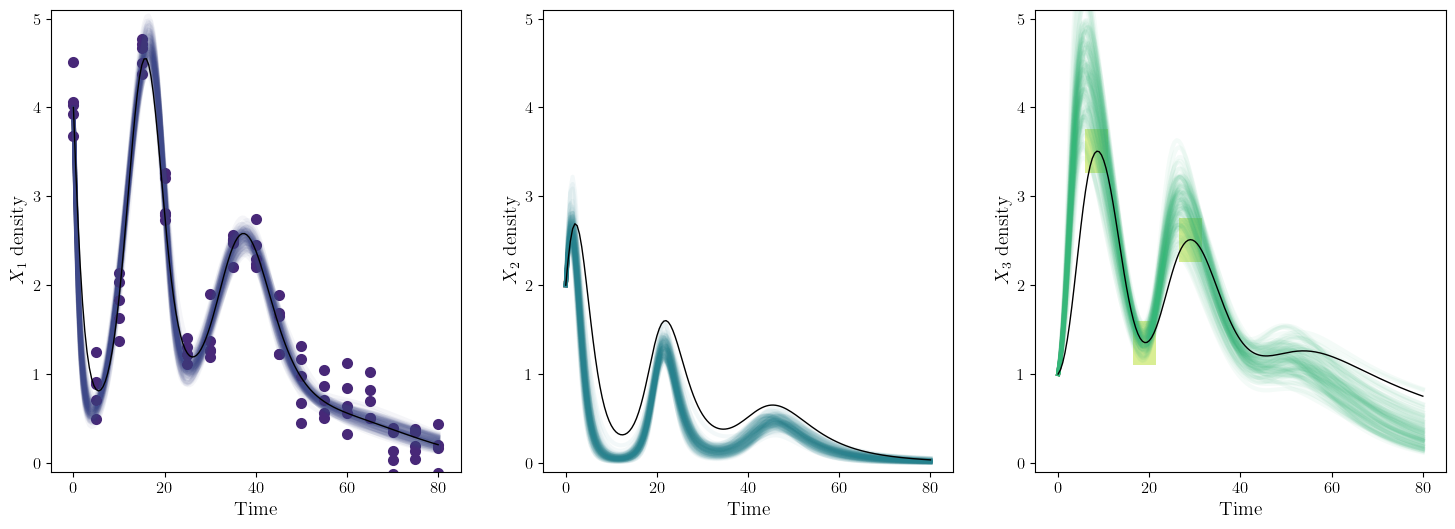

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [80]:
dfParams_x3 = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

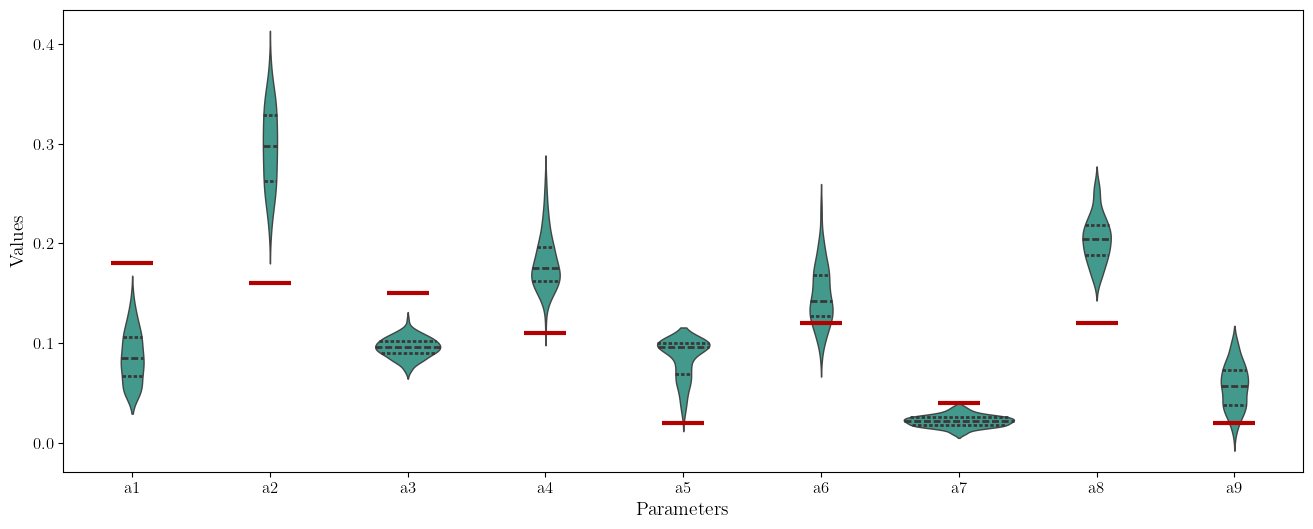

In [81]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x3, x='Parameters', y='Values',
               color=palette[4], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

### Likelihood profiles

In [120]:
df_a1 = pd.read_csv('cycle/a1Profile_x3.dat', sep=' ', names=parNames).filter(['a1', 'RMSE'])
df_a2 = pd.read_csv('cycle/a2Profile_x3.dat', sep=' ', names=parNames).filter(['a2', 'RMSE'])
df_a3 = pd.read_csv('cycle/a3Profile_x3.dat', sep=' ', names=parNames).filter(['a3', 'RMSE'])
df_a4 = pd.read_csv('cycle/a4Profile_x3.dat', sep=' ', names=parNames).filter(['a4', 'RMSE'])
df_a5 = pd.read_csv('cycle/a5Profile_x3.dat', sep=' ', names=parNames).filter(['a5', 'RMSE'])
df_a6 = pd.read_csv('cycle/a6Profile_x3.dat', sep=' ', names=parNames).filter(['a6', 'RMSE'])
df_a7 = pd.read_csv('cycle/a7Profile_x3.dat', sep=' ', names=parNames).filter(['a7', 'RMSE'])
df_a8 = pd.read_csv('cycle/a8Profile_x3.dat', sep=' ', names=parNames).filter(['a8', 'RMSE'])
df_a9 = pd.read_csv('cycle/a9Profile_x3.dat', sep=' ', names=parNames).filter(['a9', 'RMSE'])

In [121]:
df_a1 = df_a1[df_a1['RMSE'] != 1e10]
df_a2 = df_a2[df_a2['RMSE'] != 1e10]
df_a3 = df_a3[df_a3['RMSE'] != 1e10]
df_a4 = df_a4[df_a4['RMSE'] != 1e10]
df_a5 = df_a5[df_a5['RMSE'] != 1e10]
df_a6 = df_a6[df_a6['RMSE'] != 1e10]
df_a7 = df_a7[df_a7['RMSE'] != 1e10]
df_a8 = df_a8[df_a8['RMSE'] != 1e10]
df_a9 = df_a9[df_a9['RMSE'] != 1e10]

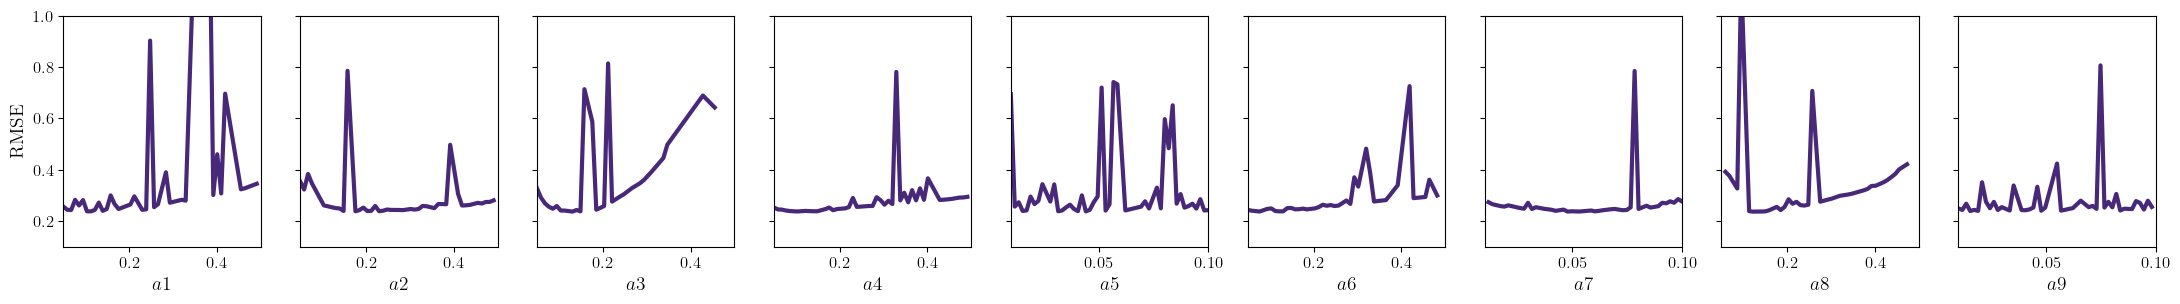

In [126]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(27,3), sharey=True, facecolor='white')

axs[0].plot(df_a1['a1'], df_a1['RMSE'], lw=3, color=palette[0])
axs[0].set_xlabel('$a1$')
axs[0].set_ylabel('RMSE')
axs[0].set_xlim((0.05,0.5))

axs[1].plot(df_a2['a2'], df_a2['RMSE'], lw=3, color=palette[0])
axs[1].set_xlabel('$a2$')
axs[1].set_xlim((0.05,0.5))

axs[2].plot(df_a3['a3'], df_a3['RMSE'], lw=3, color=palette[0])
axs[2].set_xlabel('$a3$')
axs[2].set_xlim((0.05,0.5))

axs[3].plot(df_a4['a4'], df_a4['RMSE'], lw=3, color=palette[0])
axs[3].set_xlabel('$a4$')
axs[3].set_xlim((0.05,0.5))

axs[4].plot(df_a5['a5'], df_a5['RMSE'], lw=3, color=palette[0])
axs[4].set_xlabel('$a5$')
axs[4].set_xlim((0.01,0.1))

axs[5].plot(df_a6['a6'], df_a6['RMSE'], lw=3, color=palette[0])
axs[5].set_xlabel('$a6$')
axs[5].set_xlim((0.05,0.5))

axs[6].plot(df_a7['a7'], df_a7['RMSE'], lw=3, color=palette[0])
axs[6].set_xlabel('$a7$')
axs[6].set_xlim((0.01,0.1))

axs[7].plot(df_a8['a8'], df_a8['RMSE'], lw=3, color=palette[0])
axs[7].set_xlabel('$a8$')
axs[7].set_xlim((0.05,0.5))

axs[8].plot(df_a9['a9'], df_a9['RMSE'], lw=3, color=palette[0])
axs[8].set_xlabel('$a9$')
axs[8].set_xlim((0.01,0.1))

plt.setp(axs, ylim=(0.1,1.0))

plt.show()

In [127]:
df_a1_x3 = df_a1
df_a2_x3 = df_a2
df_a3_x3 = df_a3
df_a4_x3 = df_a4
df_a5_x3 = df_a5
df_a6_x3 = df_a6
df_a7_x3 = df_a7
df_a8_x3 = df_a8
df_a9_x3 = df_a9

## Qualitative X2 and X3

In [82]:
dfParams = pd.read_csv('cycle/bestPars_x2x3.dat', sep=' ', names=parNames)

In [83]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

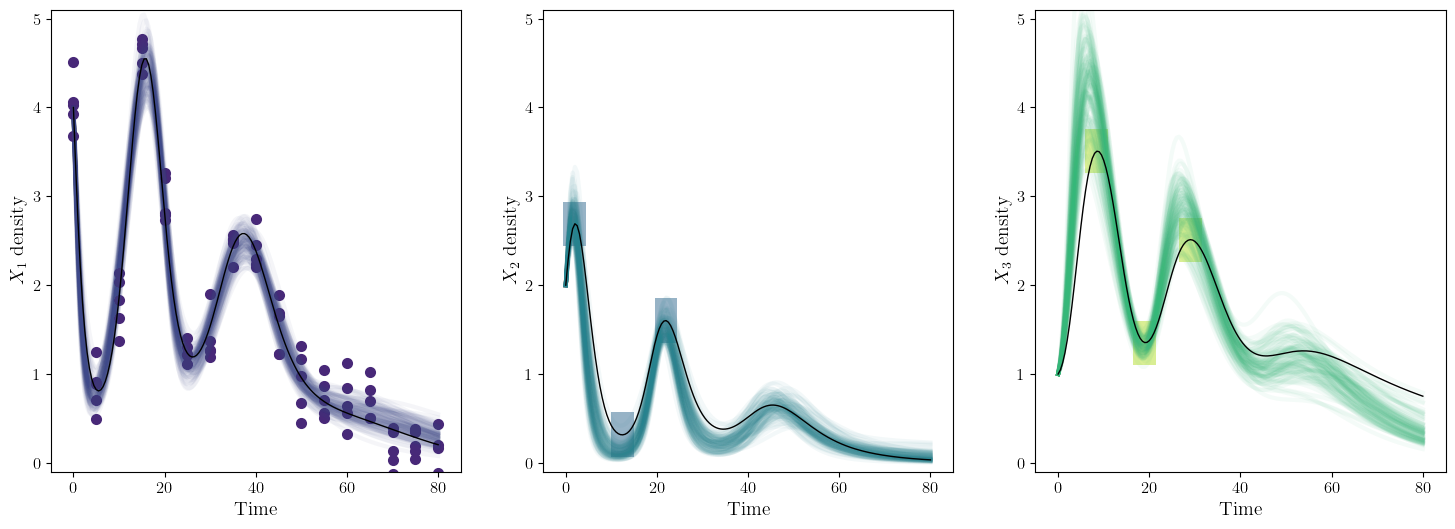

In [84]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [85]:
dfParams_x2x3 = dfParams.drop(columns=['a0', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

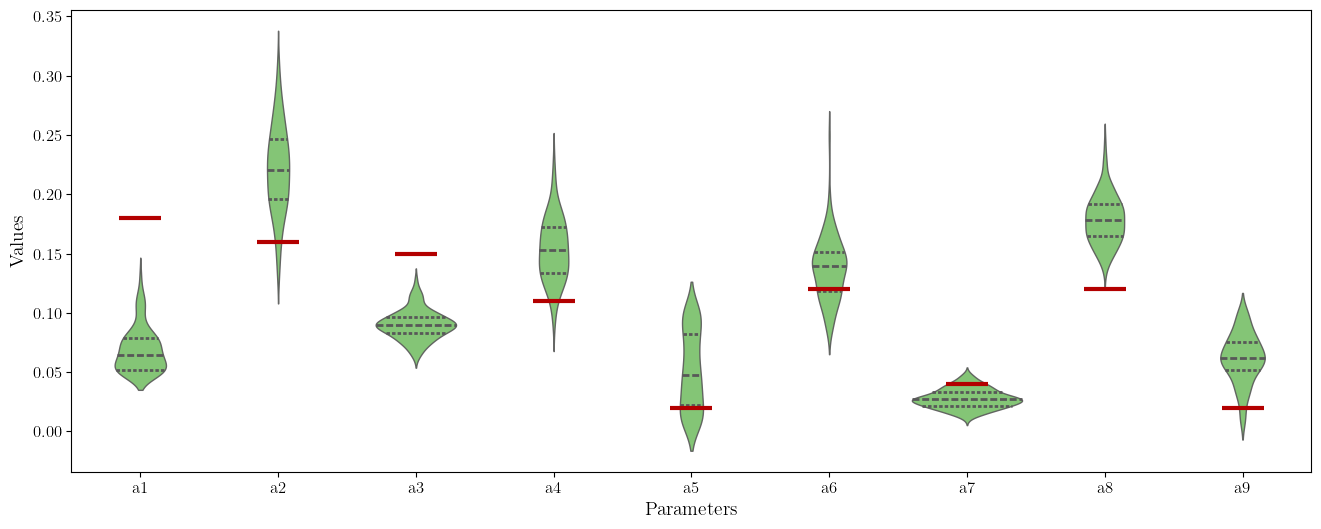

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x2x3, x='Parameters', y='Values',
               color=palette[6], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

### Likelihood profiles

In [133]:
df_a1 = pd.read_csv('cycle/a1Profile_x2x3.dat', sep=' ', names=parNames).filter(['a1', 'RMSE'])
df_a2 = pd.read_csv('cycle/a2Profile_x2x3.dat', sep=' ', names=parNames).filter(['a2', 'RMSE'])
df_a3 = pd.read_csv('cycle/a3Profile_x2x3.dat', sep=' ', names=parNames).filter(['a3', 'RMSE'])
df_a4 = pd.read_csv('cycle/a4Profile_x2x3.dat', sep=' ', names=parNames).filter(['a4', 'RMSE'])
df_a5 = pd.read_csv('cycle/a5Profile_x2x3.dat', sep=' ', names=parNames).filter(['a5', 'RMSE'])
df_a6 = pd.read_csv('cycle/a6Profile_x2x3.dat', sep=' ', names=parNames).filter(['a6', 'RMSE'])
df_a7 = pd.read_csv('cycle/a7Profile_x2x3.dat', sep=' ', names=parNames).filter(['a7', 'RMSE'])
df_a8 = pd.read_csv('cycle/a8Profile_x2x3.dat', sep=' ', names=parNames).filter(['a8', 'RMSE'])
df_a9 = pd.read_csv('cycle/a9Profile_x2x3.dat', sep=' ', names=parNames).filter(['a9', 'RMSE'])

In [134]:
df_a1 = df_a1[df_a1['RMSE'] != 1e10]
df_a2 = df_a2[df_a2['RMSE'] != 1e10]
df_a3 = df_a3[df_a3['RMSE'] != 1e10]
df_a4 = df_a4[df_a4['RMSE'] != 1e10]
df_a5 = df_a5[df_a5['RMSE'] != 1e10]
df_a6 = df_a6[df_a6['RMSE'] != 1e10]
df_a7 = df_a7[df_a7['RMSE'] != 1e10]
df_a8 = df_a8[df_a8['RMSE'] != 1e10]
df_a9 = df_a9[df_a9['RMSE'] != 1e10]

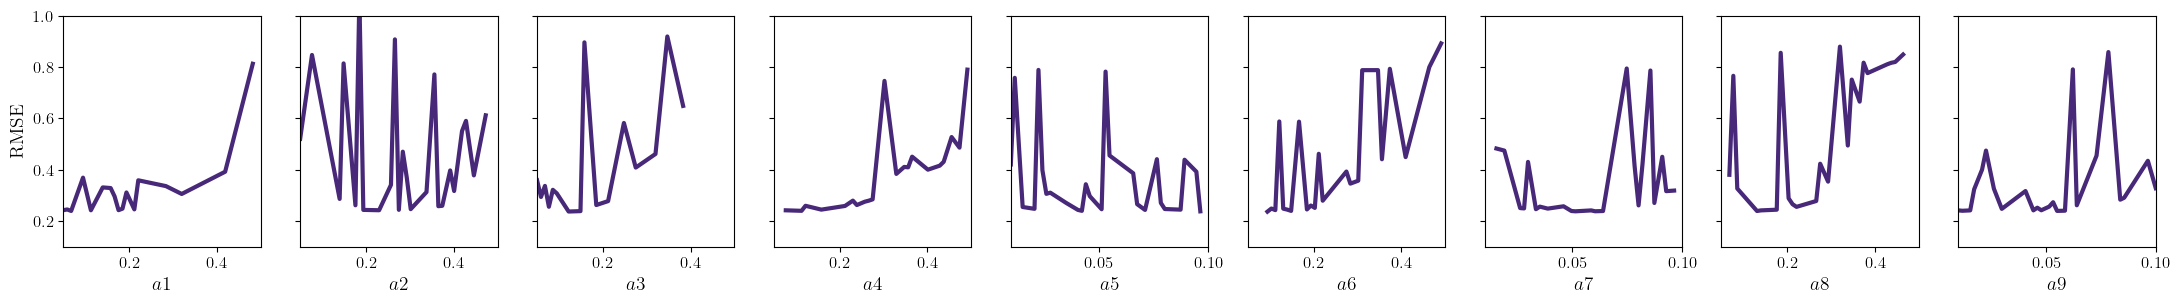

In [136]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(27,3), sharey=True, facecolor='white')

axs[0].plot(df_a1['a1'], df_a1['RMSE'], lw=3, color=palette[0])
axs[0].set_xlabel('$a1$')
axs[0].set_ylabel('RMSE')
axs[0].set_xlim((0.05,0.5))

axs[1].plot(df_a2['a2'], df_a2['RMSE'], lw=3, color=palette[0])
axs[1].set_xlabel('$a2$')
axs[1].set_xlim((0.05,0.5))

axs[2].plot(df_a3['a3'], df_a3['RMSE'], lw=3, color=palette[0])
axs[2].set_xlabel('$a3$')
axs[2].set_xlim((0.05,0.5))

axs[3].plot(df_a4['a4'], df_a4['RMSE'], lw=3, color=palette[0])
axs[3].set_xlabel('$a4$')
axs[3].set_xlim((0.05,0.5))

axs[4].plot(df_a5['a5'], df_a5['RMSE'], lw=3, color=palette[0])
axs[4].set_xlabel('$a5$')
axs[4].set_xlim((0.01,0.1))

axs[5].plot(df_a6['a6'], df_a6['RMSE'], lw=3, color=palette[0])
axs[5].set_xlabel('$a6$')
axs[5].set_xlim((0.05,0.5))

axs[6].plot(df_a7['a7'], df_a7['RMSE'], lw=3, color=palette[0])
axs[6].set_xlabel('$a7$')
axs[6].set_xlim((0.01,0.1))

axs[7].plot(df_a8['a8'], df_a8['RMSE'], lw=3, color=palette[0])
axs[7].set_xlabel('$a8$')
axs[7].set_xlim((0.05,0.5))

axs[8].plot(df_a9['a9'], df_a9['RMSE'], lw=3, color=palette[0])
axs[8].set_xlabel('$a9$')
axs[8].set_xlim((0.01,0.1))

plt.setp(axs, ylim=(0.1,1.0))

plt.show()

In [137]:
df_a1_x2x3 = df_a1
df_a2_x2x3 = df_a2
df_a3_x2x3 = df_a3
df_a4_x2x3 = df_a4
df_a5_x2x3 = df_a5
df_a6_x2x3 = df_a6
df_a7_x2x3 = df_a7
df_a8_x2x3 = df_a8
df_a9_x2x3 = df_a9

## Comparative

In [87]:
dfParams_quant['Strategie'] = 'qt X1'
dfParams_x2['Strategie'] = 'qt X1 + ql X2'
dfParams_x3['Strategie'] = 'qt X1 + ql X3'
dfParams_x2x3['Strategie'] = 'qt X1 + ql X2 + ql X3'

In [88]:
dfParams_all = pd.concat([dfParams_quant, dfParams_x2, dfParams_x3, dfParams_x2x3])
dfParams_all_cycle = dfParams_all.copy()

<Axes: xlabel='Parameters', ylabel='Values'>

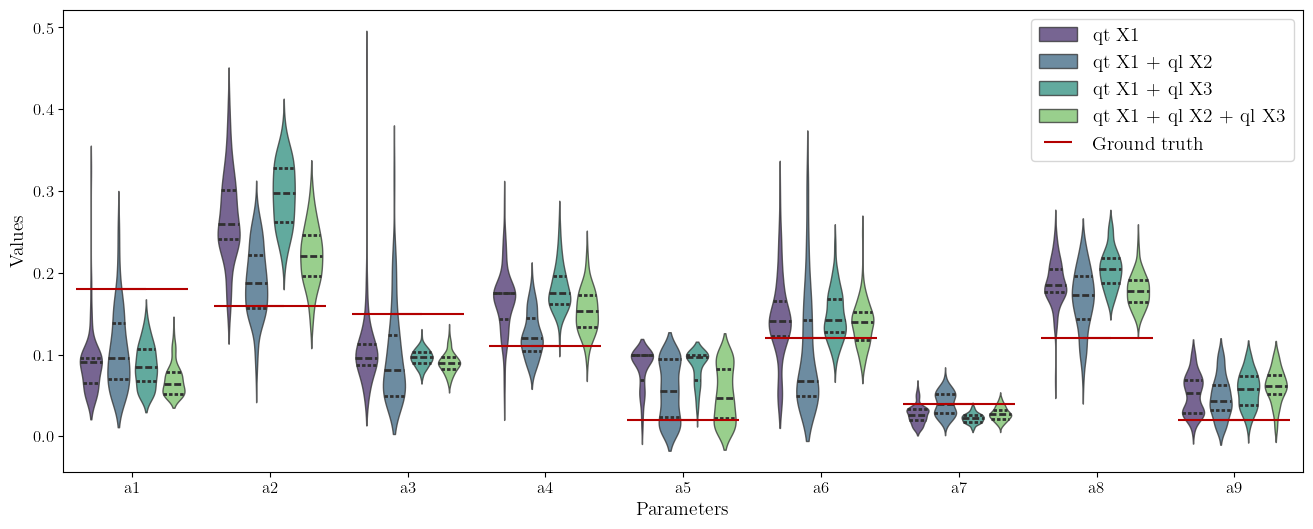

In [89]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

colors = [palette[0], palette[2], palette[4], palette[6]]

sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategie',
               palette=colors, alpha=0.75, linewidth=1, density_norm="count", gap=0.2,
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=20, markeredgewidth=1.5)

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', #label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=80, markeredgewidth=1.5)

# plt.setp(axs, ylim=(-0.01,0.61))

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

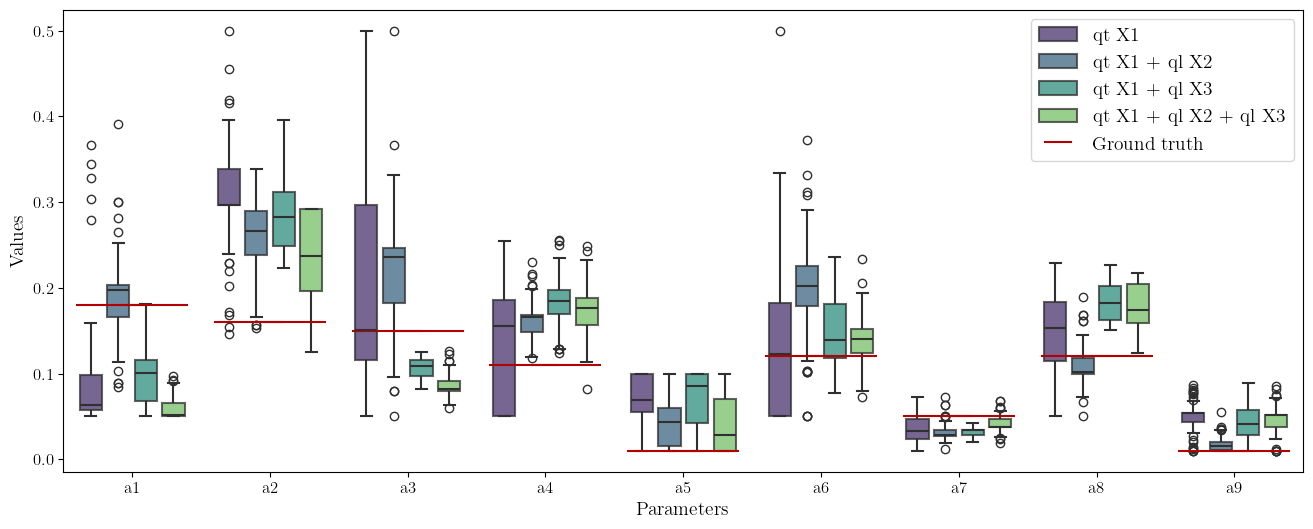

In [141]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

colors = [palette[0], palette[2], palette[4], palette[6]]

sns.boxplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategie',
               palette=colors, linewidth=1.5, gap=0.2, boxprops=dict(alpha=.75))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=20, markeredgewidth=1.5)

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', #label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=80, markeredgewidth=1.5)

# plt.setp(axs, ylim=(-0.01,0.6))

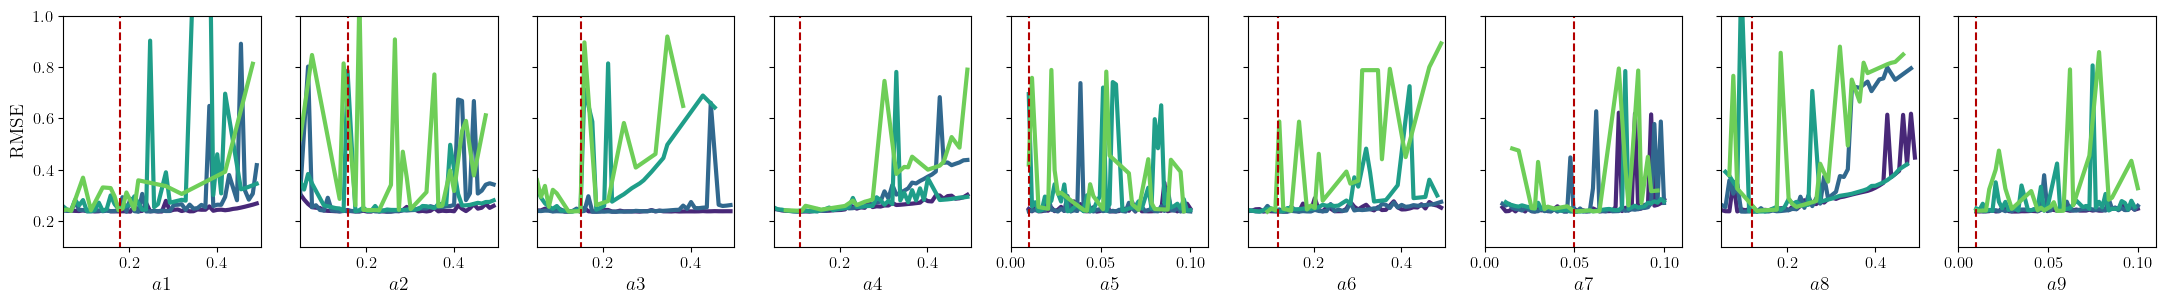

In [148]:
fig, axs = plt.subplots(nrows=1, ncols=9, figsize=(27,3), sharey=True, facecolor='white')

axs[0].plot(df_a1_quant['a1'], df_a1_quant['RMSE'], lw=3, color=palette[0])
axs[0].plot(df_a1_x2['a1'], df_a1_x2['RMSE'], lw=3, color=palette[2])
axs[0].plot(df_a1_x3['a1'], df_a1_x3['RMSE'], lw=3, color=palette[4])
axs[0].plot(df_a1_x2x3['a1'], df_a1_x2x3['RMSE'], lw=3, color=palette[6])
axs[0].vlines(dfGroundPars['a1'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[0].set_xlabel('$a1$')
axs[0].set_ylabel('RMSE')
axs[0].set_xlim((0.05,0.5))

axs[1].plot(df_a2_quant['a2'], df_a2_quant['RMSE'], lw=3, color=palette[0])
axs[1].plot(df_a2_x2['a2'], df_a2_x2['RMSE'], lw=3, color=palette[2])
axs[1].plot(df_a2_x3['a2'], df_a2_x3['RMSE'], lw=3, color=palette[4])
axs[1].plot(df_a2_x2x3['a2'], df_a2_x2x3['RMSE'], lw=3, color=palette[6])
axs[1].vlines(dfGroundPars['a2'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[1].set_xlabel('$a2$')
axs[1].set_xlim((0.05,0.5))

axs[2].plot(df_a3_quant['a3'], df_a3_quant['RMSE'], lw=3, color=palette[0])
axs[2].plot(df_a3_x2['a3'], df_a3_x2['RMSE'], lw=3, color=palette[2])
axs[2].plot(df_a3_x3['a3'], df_a3_x3['RMSE'], lw=3, color=palette[4])
axs[2].plot(df_a3_x2x3['a3'], df_a3_x2x3['RMSE'], lw=3, color=palette[6])
axs[2].vlines(dfGroundPars['a3'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[2].set_xlabel('$a3$')
axs[2].set_xlim((0.05,0.5))

axs[3].plot(df_a4_quant['a4'], df_a4_quant['RMSE'], lw=3, color=palette[0])
axs[3].plot(df_a4_x2['a4'], df_a4_x2['RMSE'], lw=3, color=palette[2])
axs[3].plot(df_a4_x3['a4'], df_a4_x3['RMSE'], lw=3, color=palette[4])
axs[3].plot(df_a4_x2x3['a4'], df_a4_x2x3['RMSE'], lw=3, color=palette[6])
axs[3].vlines(dfGroundPars['a4'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[3].set_xlabel('$a4$')
axs[3].set_xlim((0.05,0.5))

axs[4].plot(df_a5_quant['a5'], df_a5_quant['RMSE'], lw=3, color=palette[0])
axs[4].plot(df_a5_x2['a5'], df_a5_x2['RMSE'], lw=3, color=palette[2])
axs[4].plot(df_a5_x3['a5'], df_a5_x3['RMSE'], lw=3, color=palette[4])
axs[4].plot(df_a5_x2x3['a5'], df_a5_x2x3['RMSE'], lw=3, color=palette[6])
axs[4].vlines(dfGroundPars['a5'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[4].set_xlabel('$a5$')
axs[4].set_xlim((0.0,0.11))

axs[5].plot(df_a6_quant['a6'], df_a6_quant['RMSE'], lw=3, color=palette[0])
axs[5].plot(df_a6_x2['a6'], df_a6_x2['RMSE'], lw=3, color=palette[2])
axs[5].plot(df_a6_x3['a6'], df_a6_x3['RMSE'], lw=3, color=palette[4])
axs[5].plot(df_a6_x2x3['a6'], df_a6_x2x3['RMSE'], lw=3, color=palette[6])
axs[5].vlines(dfGroundPars['a6'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[5].set_xlabel('$a6$')
axs[5].set_xlim((0.05,0.5))

axs[6].plot(df_a7_quant['a7'], df_a7_quant['RMSE'], lw=3, color=palette[0])
axs[6].plot(df_a7_x2['a7'], df_a7_x2['RMSE'], lw=3, color=palette[2])
axs[6].plot(df_a7_x3['a7'], df_a7_x3['RMSE'], lw=3, color=palette[4])
axs[6].plot(df_a7_x2x3['a7'], df_a7_x2x3['RMSE'], lw=3, color=palette[6])
axs[6].vlines(dfGroundPars['a7'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[6].set_xlabel('$a7$')
axs[6].set_xlim((0.0,0.11))

axs[7].plot(df_a8_quant['a8'], df_a8_quant['RMSE'], lw=3, color=palette[0])
axs[7].plot(df_a8_x2['a8'], df_a8_x2['RMSE'], lw=3, color=palette[2])
axs[7].plot(df_a8_x3['a8'], df_a8_x3['RMSE'], lw=3, color=palette[4])
axs[7].plot(df_a8_x2x3['a8'], df_a8_x2x3['RMSE'], lw=3, color=palette[6])
axs[7].vlines(dfGroundPars['a8'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[7].set_xlabel('$a8$')
axs[7].set_xlim((0.05,0.5))

axs[8].plot(df_a9_quant['a9'], df_a9_quant['RMSE'], lw=3, color=palette[0])
axs[8].plot(df_a9_x2['a9'], df_a9_x2['RMSE'], lw=3, color=palette[2])
axs[8].plot(df_a9_x3['a9'], df_a9_x3['RMSE'], lw=3, color=palette[4])
axs[8].plot(df_a9_x2x3['a9'], df_a9_x2x3['RMSE'], lw=3, color=palette[6])
axs[8].vlines(dfGroundPars['a9'], ymin=0.0, ymax=1.0, colors="#b30000", linestyles='dashed')
axs[8].set_xlabel('$a9$')
axs[8].set_xlim((0.0,0.11))

plt.setp(axs, ylim=(0.1,1.0))

plt.show()

# Lotka-Volterra equations (Linear model)

\begin{align}
\dot X_1 &= a_0 X_1 - a_2 X_1 X_2 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 - a_6 X_2 X_3 \\
\dot X_3 &= a_8 X_2 X_3 - a_9 X_3 \\
\end{align}

In [247]:
a0 = 0.14 # Reproduction rate of X1
a1 = 0.0 # Mortality rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = 0.0 # Reproduction rate of X1 in presence of X3
a4 = 0.15 # Reproduction rate of X2 in presence of X1
a5 = 0.11 # Mortality rate of X2
a6 = 0.05 # Rate of predation of X3 on X2
a7 = 0.0 # Rate of predation of X1 on X3
a8 = 0.06 # Reproduction rate of X3 in presence of X2
a9 = 0.05 # Mortality rate of X3

In [248]:
names=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']

In [249]:
dfGroundPars = pd.DataFrame([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9]).T
dfGroundPars.columns = names

In [138]:
dfGroundPars

a0   a1    a2   a3    a4    a5    a6   a7    a8    a9
0  0.14  0.0  0.16  0.0  0.15  0.11  0.05  0.0  0.06  0.05

# Generating data

In [139]:
a0 = dfGroundPars['a0'][0]
a1 = dfGroundPars['a1'][0]
a2 = dfGroundPars['a2'][0]
a3 = dfGroundPars['a3'][0]
a4 = dfGroundPars['a4'][0]
a5 = dfGroundPars['a5'][0]
a6 = dfGroundPars['a6'][0]
a7 = dfGroundPars['a7'][0]
a8 = dfGroundPars['a8'][0]
a9 = dfGroundPars['a9'][0]

In [140]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

In [141]:
sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))

In [142]:
X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

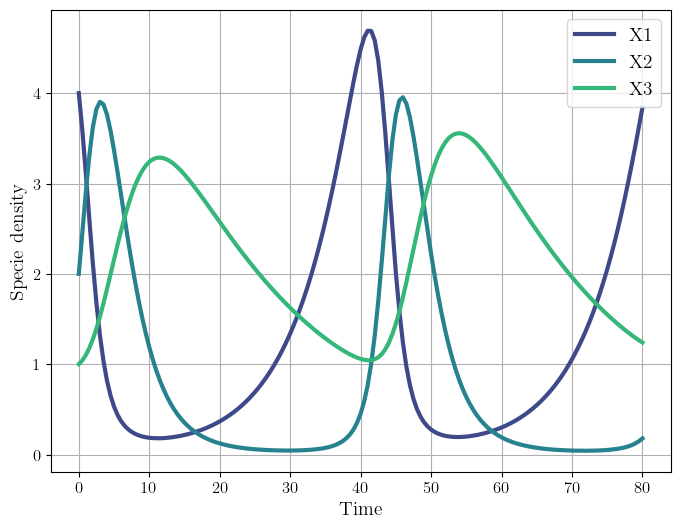

In [143]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X1_g, lw=3, color=palette[1], label='X1')
axs.plot(t, X2_g, lw=3, color=palette[3], label='X2')
axs.plot(t, X3_g, lw=3, color=palette[5], label='X3')
axs.legend(loc='best')
axs.set_xlabel('Time')
axs.set_ylabel('Specie density')
axs.grid()

plt.show()

In [144]:
# dfData_clean = pd.DataFrame(np.transpose([t[0::10],X1_g[0::10],X2_g[0::10],X3_g[0::10]]), columns=['Time','X1','X2','X3'])
dfData_clean = pd.DataFrame(np.transpose([t, X1_g, X2_g, X3_g]), columns=['Time','X1','X2','X3'])

# Recovering parameters

In [145]:
dfParams_ground = dfGroundPars.drop(columns=['a1', 'a3', 'a7']).melt(var_name='Parameters', value_name='Values')

In [146]:
parNames=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'RMSE']

In [147]:
dfData = pd.read_csv('linear/LVdata_noise.data', sep=' ')

## Quantitative X1

In [148]:
dfParams = pd.read_csv('linear/bestPars_quant.dat', sep=' ', names=parNames)

In [149]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

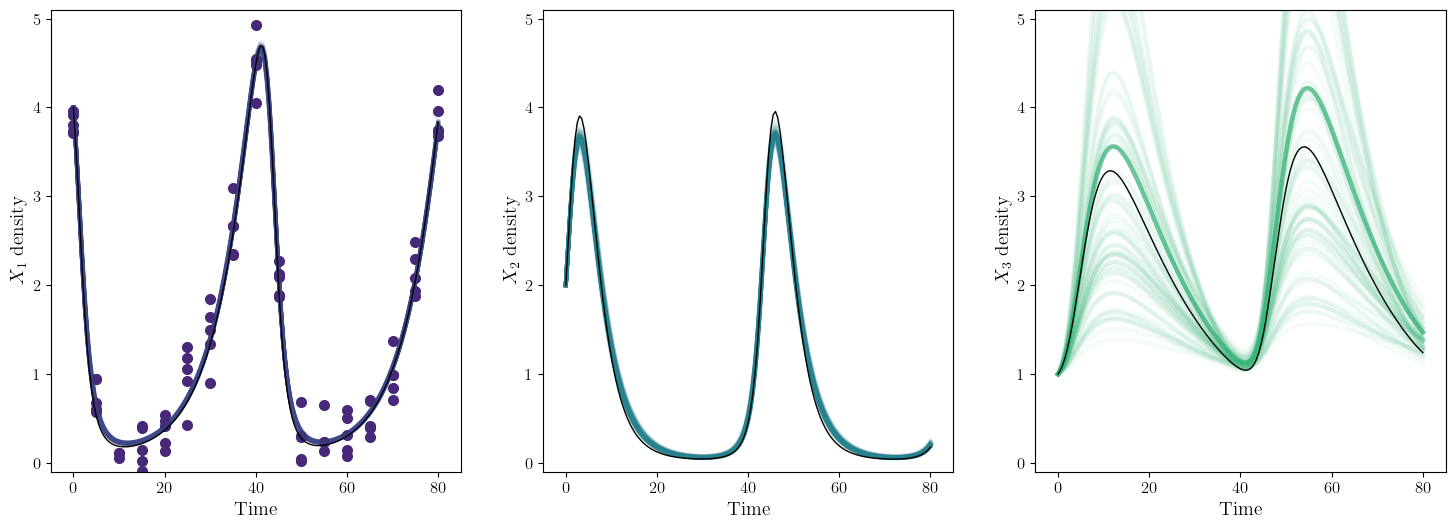

In [150]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [151]:
dfParams_quant = dfParams.drop(columns=['a1', 'a3', 'a7', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

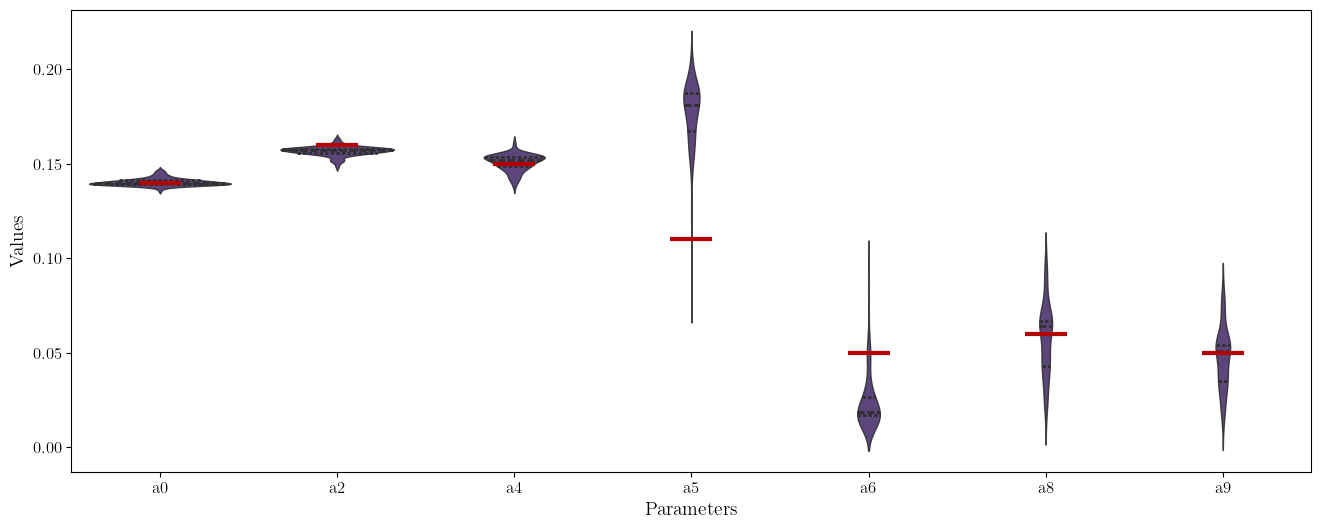

In [152]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_quant, x='Parameters', y='Values',
               color=palette[0], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Qualitative X2

In [153]:
dfQual_x2 = pd.read_csv('linear/LVdata_qual_x2.data', sep=' ')

In [154]:
dfParams = pd.read_csv('linear/bestPars_x2.dat', sep=' ', names=parNames)

In [155]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

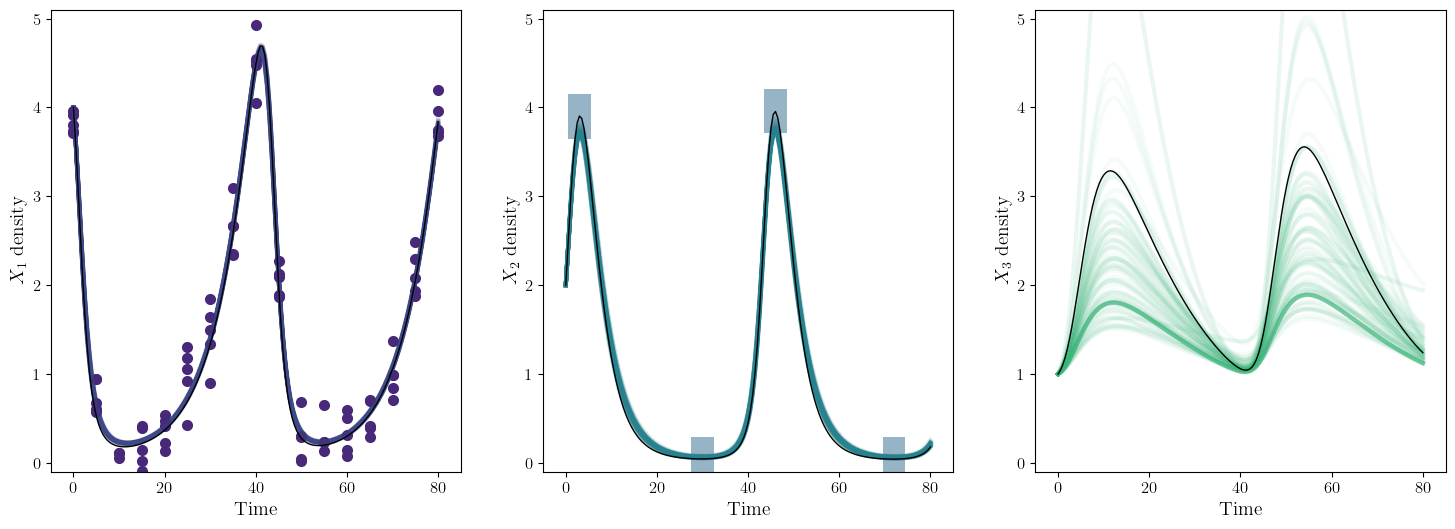

In [156]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [157]:
dfParams_x2 = dfParams.drop(columns=['a1', 'a3', 'a7', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

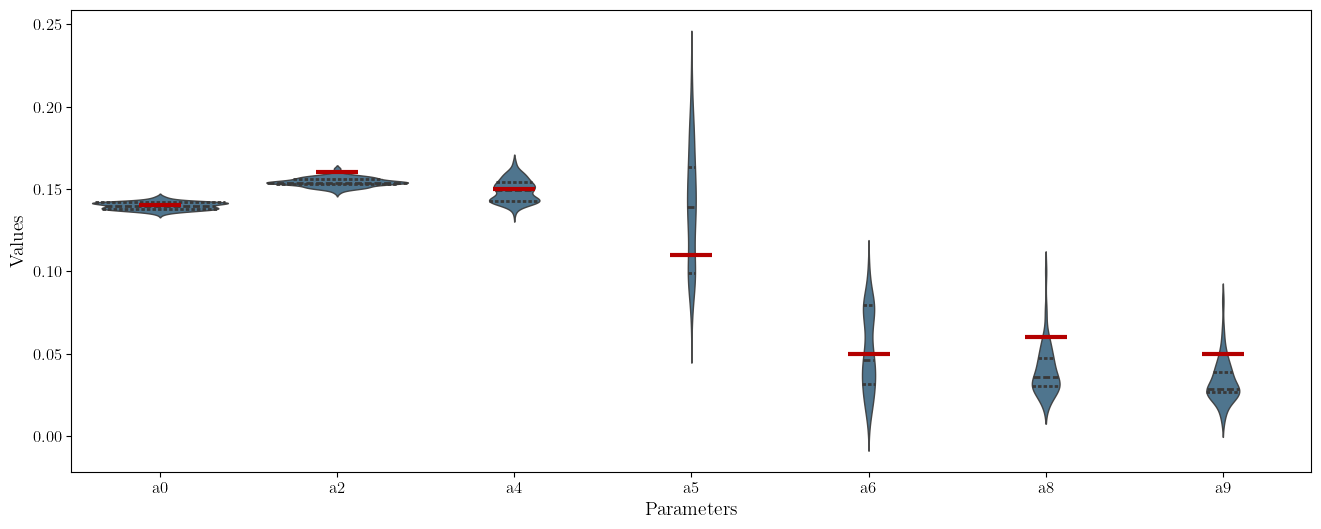

In [158]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x2, x='Parameters', y='Values',
               color=palette[2], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Qualitative X3

In [159]:
dfQual_x3 = pd.read_csv('linear/LVdata_qual_x3.data', sep=' ')

In [160]:
dfParams = pd.read_csv('linear/bestPars_x3.dat', sep=' ', names=parNames)

In [161]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

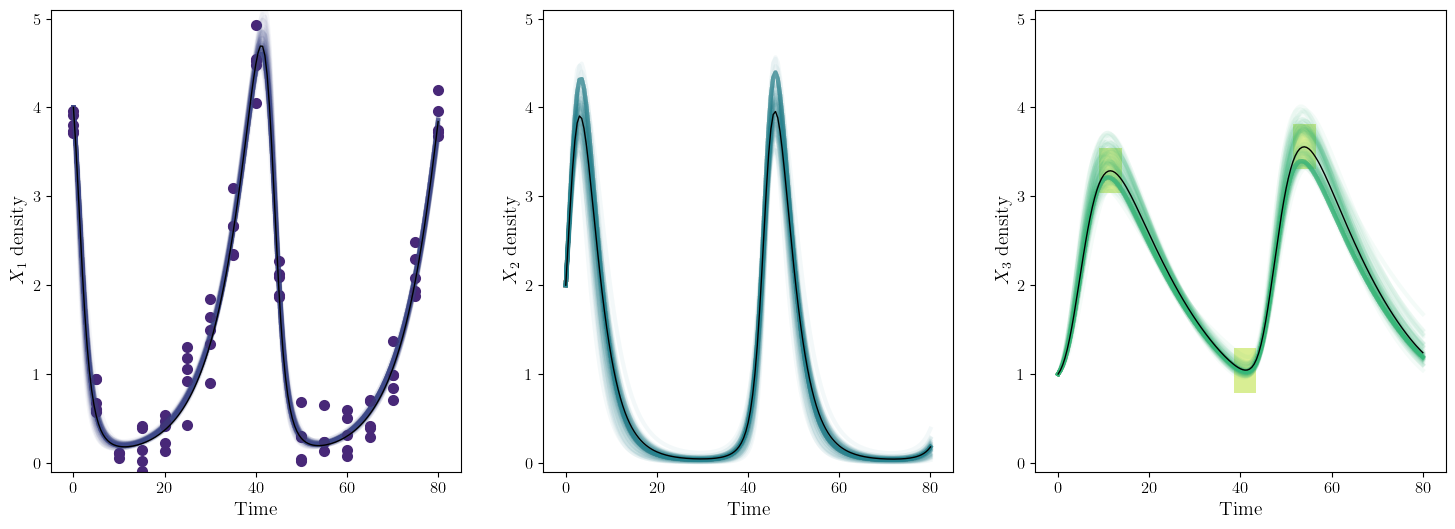

In [162]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [163]:
dfParams_x3 = dfParams.drop(columns=['a1', 'a3', 'a7', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

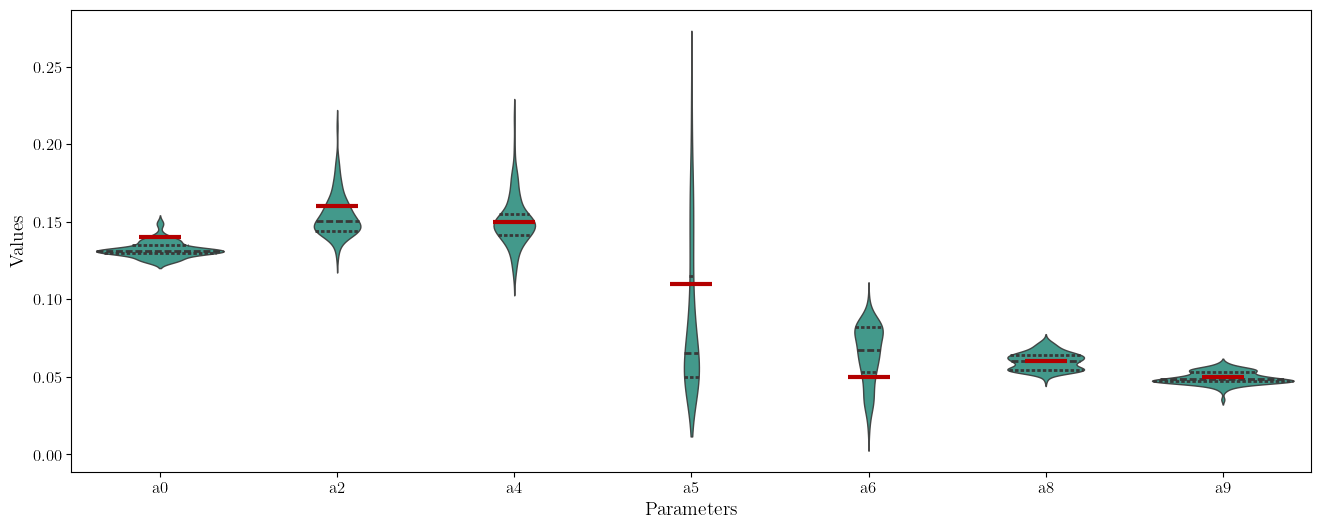

In [164]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x3, x='Parameters', y='Values',
               color=palette[4], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Qualitative X2 and X3

In [165]:
dfParams = pd.read_csv('linear/bestPars_x2x3.dat', sep=' ', names=parNames)

In [166]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

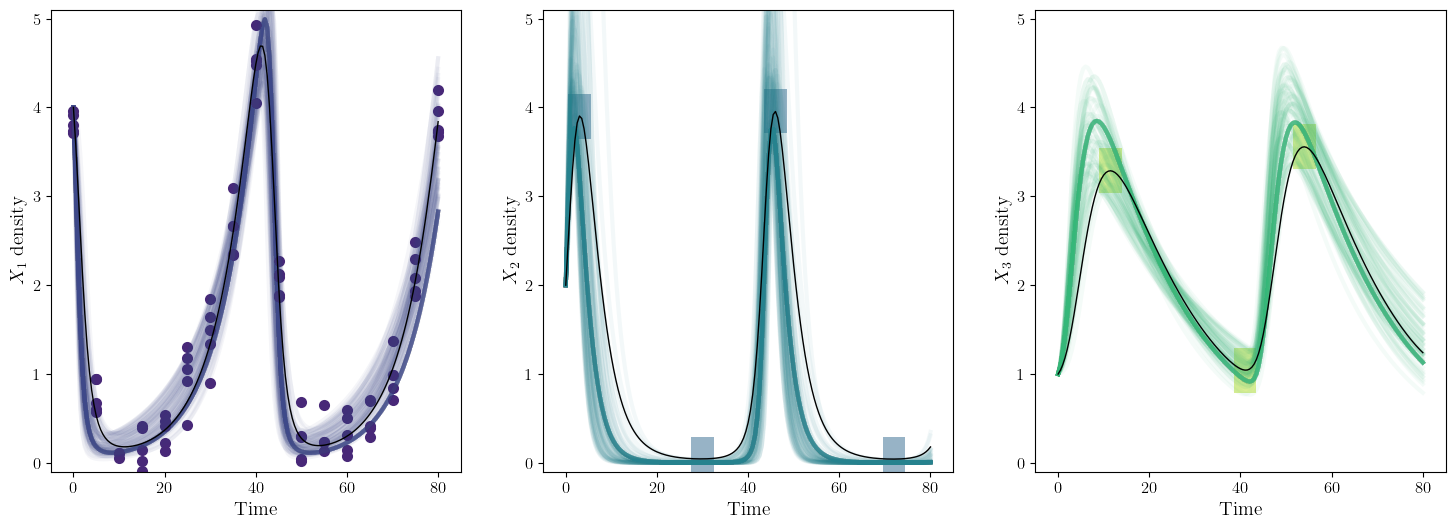

In [167]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [168]:
dfParams_x2x3 = dfParams.drop(columns=['a1', 'a3', 'a7', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

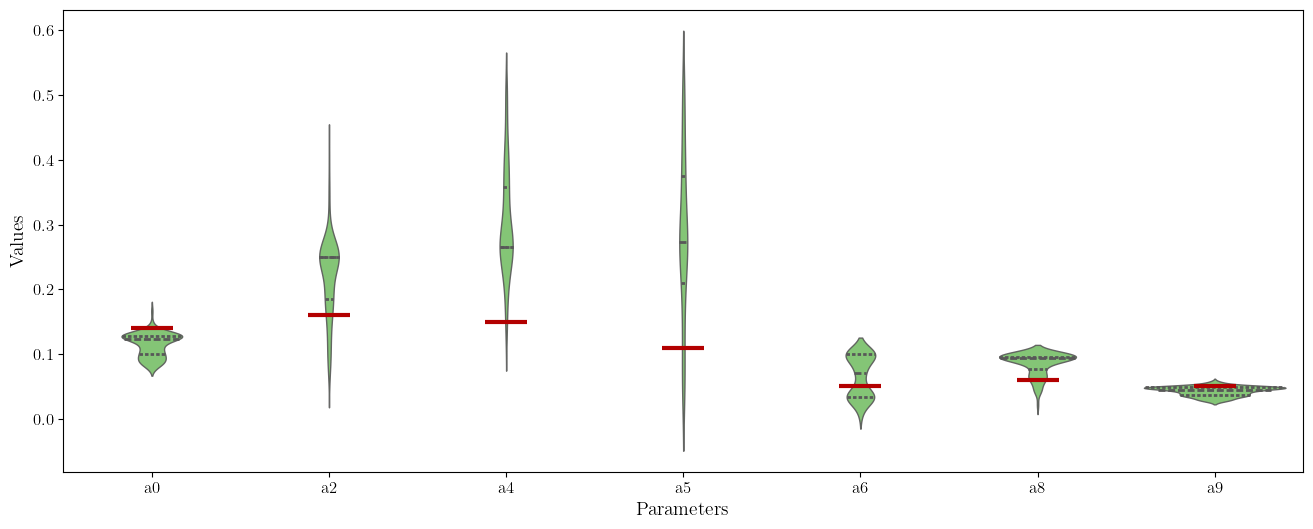

In [169]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x2x3, x='Parameters', y='Values',
               color=palette[6], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Comparative

In [170]:
dfParams_quant['Strategie'] = 'qt X1'
dfParams_x2['Strategie'] = 'qt X1 + ql X2'
dfParams_x3['Strategie'] = 'qt X1 + ql X3'
dfParams_x2x3['Strategie'] = 'qt X1 + ql X2 + ql X3'

In [171]:
dfParams_all = pd.concat([dfParams_quant, dfParams_x2, dfParams_x3, dfParams_x2x3])
dfParams_all_linear = dfParams_all.copy()

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

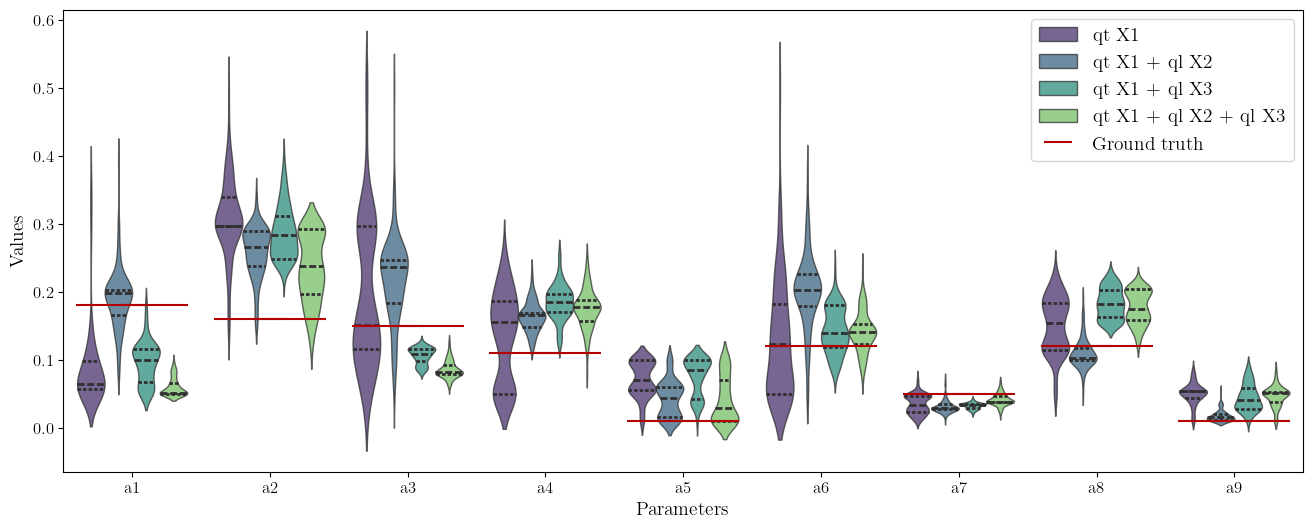

In [246]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

colors = [palette[0], palette[2], palette[4], palette[6]]

sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategie',
               palette=colors, alpha=0.75, linewidth=1, density_norm="count",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=20, markeredgewidth=1.5)

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', #label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=80, markeredgewidth=1.5)

# plt.setp(axs, ylim=(-0.01,0.61))

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

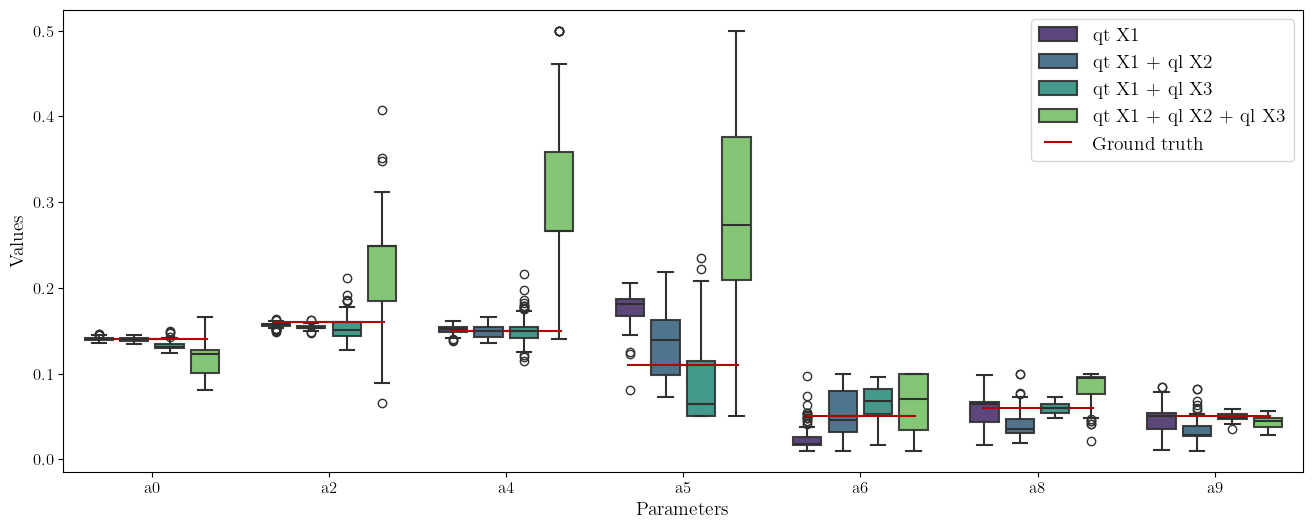

In [173]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

colors = [palette[0], palette[2], palette[4], palette[6]]

sns.boxplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategie',
               palette=colors, linewidth=1.5, gap=0.2, boxprops=dict(alpha=.9))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=20, markeredgewidth=1.5)

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', #label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=80, markeredgewidth=1.5)

# plt.setp(axs, ylim=(-0.01,0.6))

# Lotka-Volterra equations (2-predators model)

\begin{align}
\dot X_1 &= a_0 X_1 - a_2 X_1 X_2 - a_3 X_1 X_3 \\
\dot X_2 &= a_4 X_1 X_2 - a_5 X_2 \\
\dot X_3 &= a_7 X_1 X_3 - a_9 X_3 \\
\end{align}

In [82]:
a0 = 0.45 # Reproduction rate of X1
a1 = 0.0 # Mortality rate of X1
a2 = 0.16 # Rate of predation of X2 on X1
a3 = -0.15 # Reproduction rate of X1 in presence of X3
a4 = 0.15 # Reproduction rate of X2 in presence of X1
a5 = 0.11 # Mortality rate of X2
a6 = 0.0 # Rate of predation of X3 on X2
a7 = -0.08 # Rate of predation of X1 on X3
a8 = 0.0 # Reproduction rate of X3 in presence of X2
a9 = 0.05 # Mortality rate of X3

In [83]:
names=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9']

In [84]:
dfGroundPars = pd.DataFrame([a0, a1, a2, a3, a4, a5, a6, a7, a8, a9]).T
dfGroundPars.columns = names

In [85]:
dfGroundPars

a0   a1    a2    a3    a4    a5   a6    a7   a8    a9
0  0.45  0.0  0.16 -0.15  0.15  0.11  0.0 -0.08  0.0  0.05

# Generating data

In [86]:
a0 = dfGroundPars['a0'][0]
a1 = dfGroundPars['a1'][0]
a2 = dfGroundPars['a2'][0]
a3 = dfGroundPars['a3'][0]
a4 = dfGroundPars['a4'][0]
a5 = dfGroundPars['a5'][0]
a6 = dfGroundPars['a6'][0]
a7 = dfGroundPars['a7'][0]
a8 = dfGroundPars['a8'][0]
a9 = dfGroundPars['a9'][0]

In [87]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)
dt = t[1]-t[0]

In [88]:
sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))

In [89]:
X1_g = sol[:,0]
X2_g = sol[:,1]
X3_g = sol[:,2]

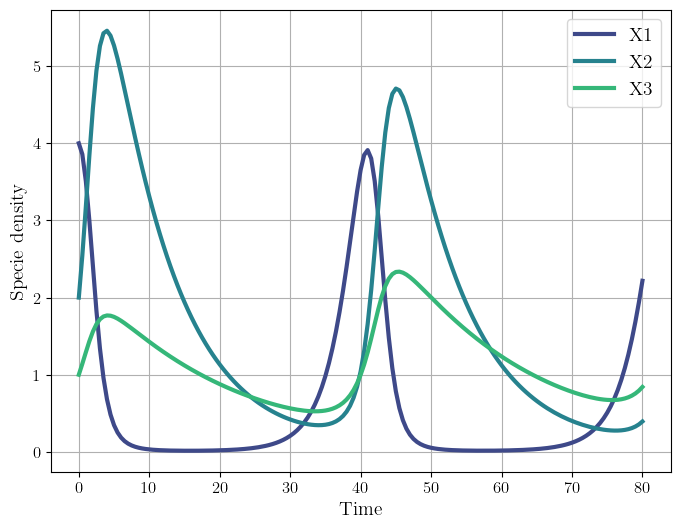

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

axs.plot(t, X1_g, lw=3, color=palette[1], label='X1')
axs.plot(t, X2_g, lw=3, color=palette[3], label='X2')
axs.plot(t, X3_g, lw=3, color=palette[5], label='X3')
axs.legend(loc='best')
axs.set_xlabel('Time')
axs.set_ylabel('Specie density')
axs.grid()

plt.show()

In [91]:
dfData_clean = pd.DataFrame(np.transpose([t[0::10],X1_g[0::10],X2_g[0::10],X3_g[0::10]]), columns=['Time','X1','X2','X3'])
# dfData_clean = pd.DataFrame(np.transpose([t, X1_g, X2_g, X3_g]), columns=['Time','X1','X2','X3'])

# Recovering parameters

In [92]:
dfParams_ground = dfGroundPars.drop(columns=['a1', 'a6', 'a8']).melt(var_name='Parameters', value_name='Values')

In [93]:
parNames=['a0', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'RMSE']

In [94]:
dfData = pd.read_csv('2-predators/LVdata_noise.data', sep=' ')

## Quantitative X1

In [95]:
dfParams = pd.read_csv('2-predators/bestPars_quant.dat', sep=' ', names=parNames)

In [96]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

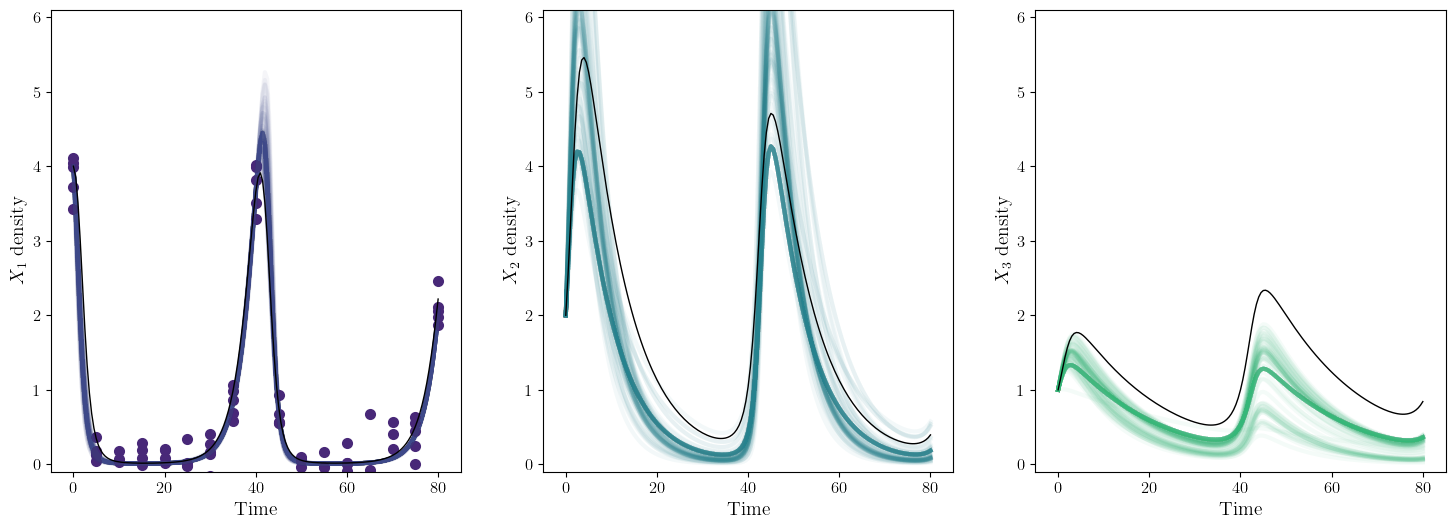

In [97]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,6.1), xlabel='Time')

plt.show()

In [98]:
dfParams_quant = dfParams.drop(columns=['a1', 'a6', 'a8', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

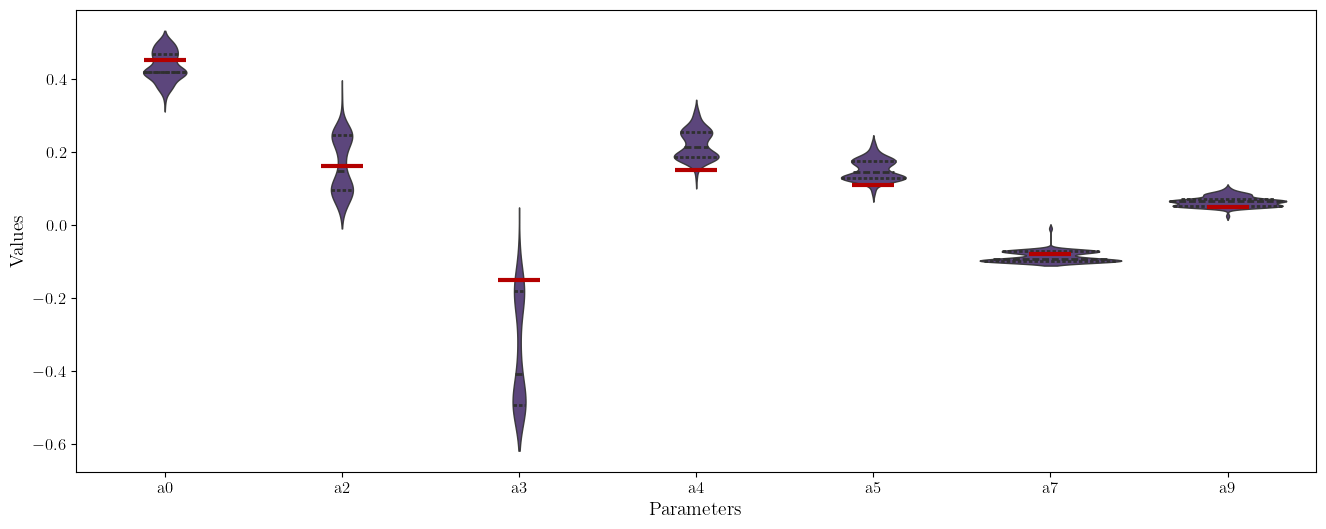

In [99]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_quant, x='Parameters', y='Values',
               color=palette[0], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Qualitative X2

In [100]:
dfQual_x2 = pd.read_csv('2-predators/LVdata_qual_x2.data', sep=' ')

In [101]:
dfParams = pd.read_csv('2-predators/bestPars_x2.dat', sep=' ', names=parNames)

In [102]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

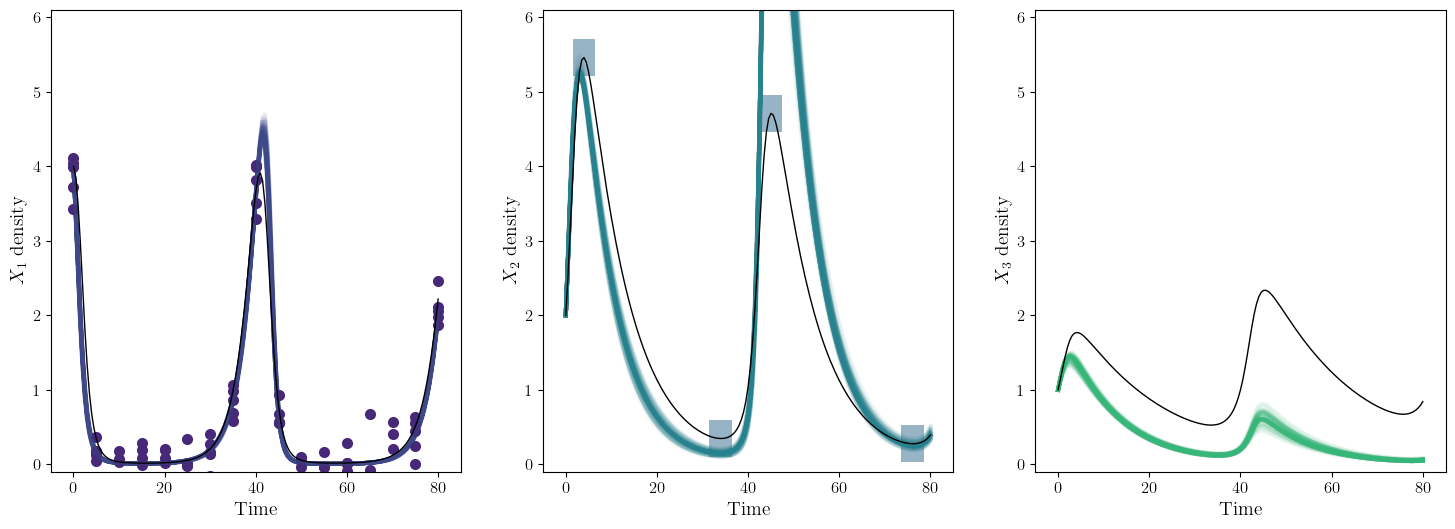

In [103]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,6.1), xlabel='Time')

plt.show()

In [104]:
dfParams_x2 = dfParams.drop(columns=['a1', 'a6', 'a8', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

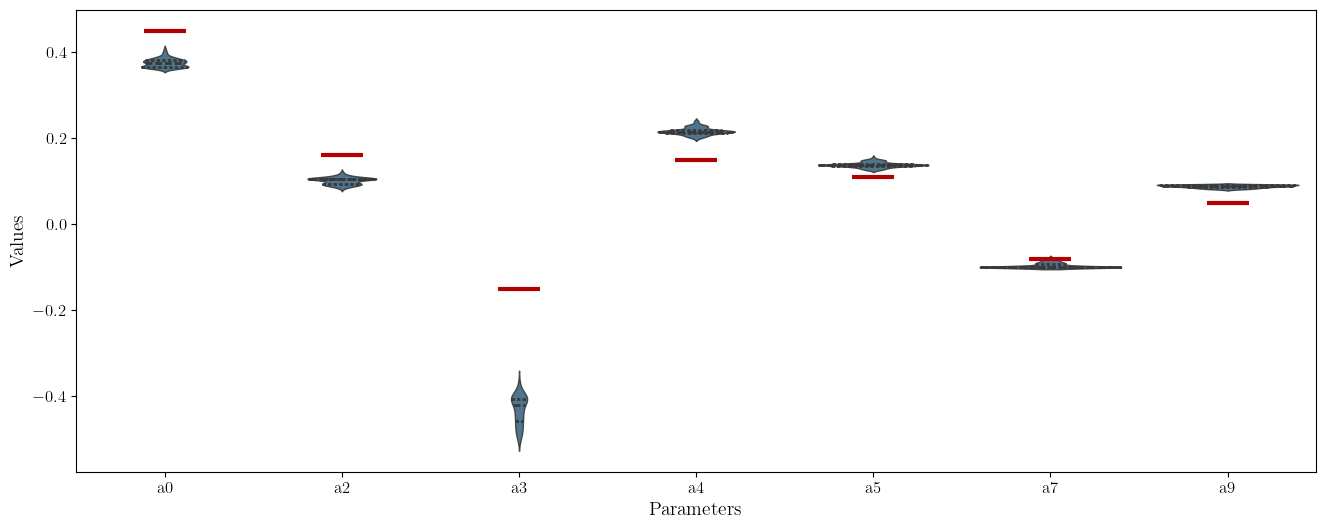

In [105]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x2, x='Parameters', y='Values',
               color=palette[2], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Qualitative X3

In [106]:
dfQual_x3 = pd.read_csv('2-predators/LVdata_qual_x3.data', sep=' ')

In [107]:
dfParams = pd.read_csv('2-predators/bestPars_x3.dat', sep=' ', names=parNames)

In [108]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

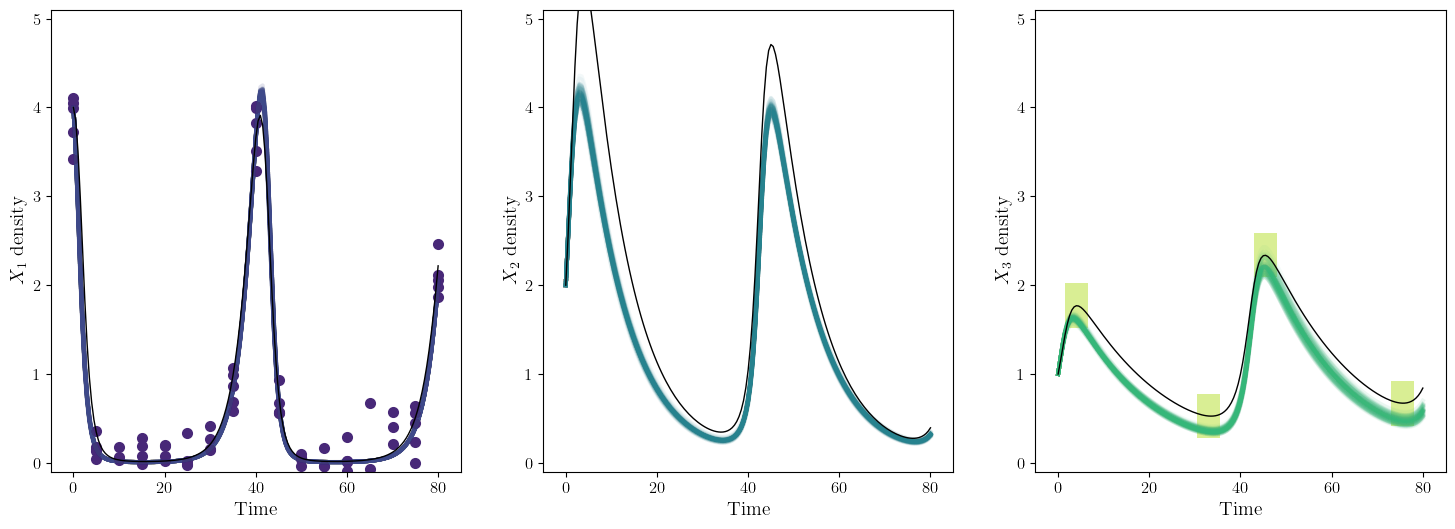

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,5.1), xlabel='Time')

plt.show()

In [110]:
dfParams_x3 = dfParams.drop(columns=['a1', 'a6', 'a8', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

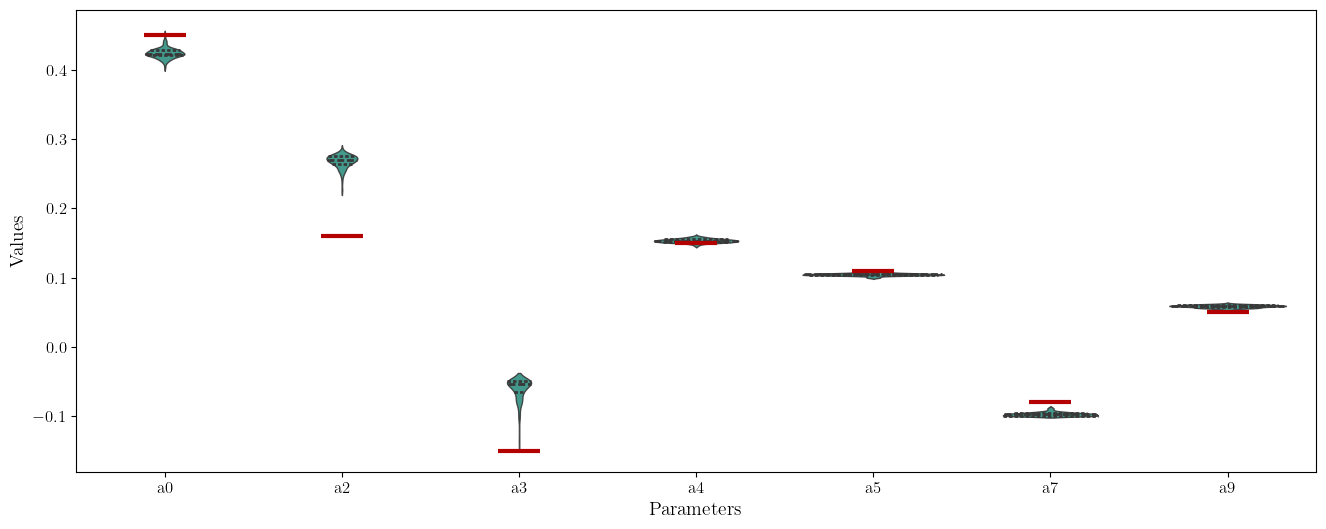

In [111]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x3, x='Parameters', y='Values',
               color=palette[4], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Qualitative X2 and X3

In [112]:
dfParams = pd.read_csv('2-predators/bestPars_x2x3.dat', sep=' ', names=parNames)

In [113]:
X1_0 = 4
X2_0 = 2
X3_0 = 1
Y0 = [X1_0, X2_0, X3_0]

t = np.linspace(0, 80, 161)

X1 = []
X2 = []
X3 = []

for i in range(dfParams.shape[0]):
    a0 = dfParams['a0'][i]
    a1 = dfParams['a1'][i]
    a2 = dfParams['a2'][i]
    a3 = dfParams['a3'][i]
    a4 = dfParams['a4'][i]
    a5 = dfParams['a5'][i]
    a6 = dfParams['a6'][i]
    a7 = dfParams['a7'][i]
    a8 = dfParams['a8'][i]
    a9 = dfParams['a9'][i]

    sol = odeint(modelLV, Y0, t, args=(a0, a1, a2, a3, a4, a5, a6, a7, a8, a9))
    X1.append(sol[:,0])
    X2.append(sol[:,1])
    X3.append(sol[:,2])

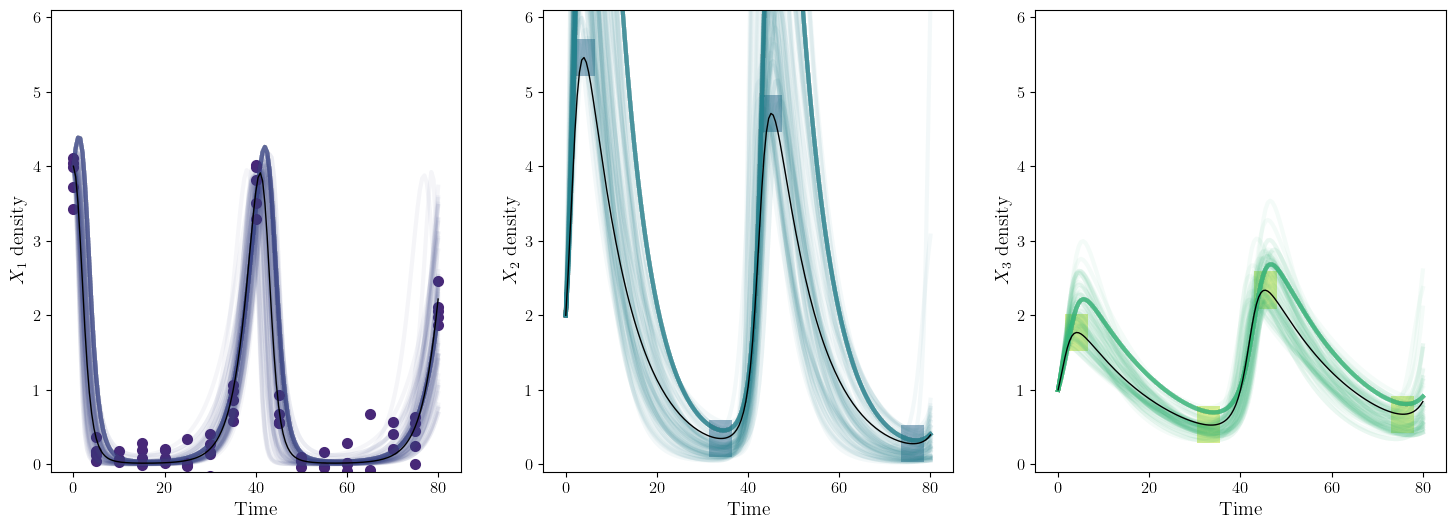

In [114]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18,6), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, X1[i], lw=3, color=palette[1], alpha=0.05)
    axs[1].plot(t, X2[i], lw=3, color=palette[3], alpha=0.05)
    axs[2].plot(t, X3[i], lw=3, color=palette[5], alpha=0.05)


axs[0].scatter(x=dfData['Time'], y=dfData['X1'], color=palette[0], lw=2)

timeWindow = 5
valueWindow = 0.5

for i in range(len(dfQual_x2['Time'])):
    rect = plt.Rectangle((dfQual_x2['Time'].values[i]- timeWindow/2, dfQual_x2['X2'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[2], alpha = 0.5)
    axs[1].add_patch(rect)
    
for i in range(len(dfQual_x3['Time'])):
    rect = plt.Rectangle((dfQual_x3['Time'].values[i]- timeWindow/2, dfQual_x3['X3'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[2].add_patch(rect)

axs[0].plot(t, X1_g, lw=1, color='k')
axs[1].plot(t, X2_g, lw=1, color='k')
axs[2].plot(t, X3_g, lw=1, color='k')

axs[0].set_ylabel('$X_1$ density')
axs[1].set_ylabel('$X_2$ density')
axs[2].set_ylabel('$X_3$ density')

plt.setp(axs, xlim=(-5,85), ylim=(-0.1,6.1), xlabel='Time')

plt.show()

In [115]:
dfParams_x2x3 = dfParams.drop(columns=['a1', 'a6', 'a8', 'RMSE']).melt(var_name='Parameters', value_name='Values')

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

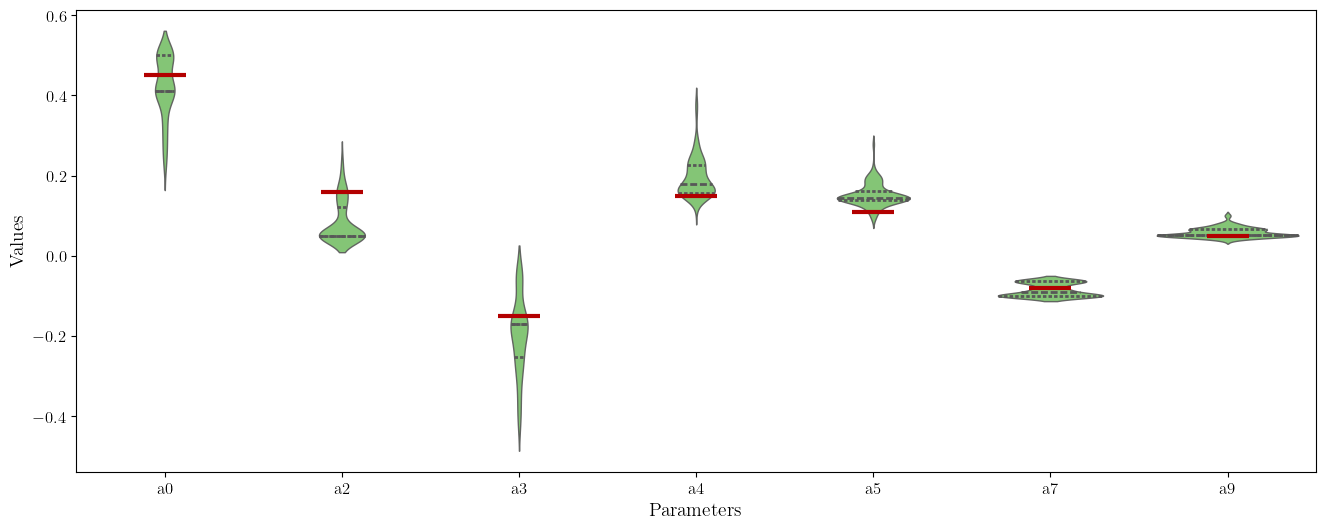

In [116]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

sns.violinplot(data=dfParams_x2x3, x='Parameters', y='Values',
               color=palette[6], alpha=0.9, linewidth=1, density_norm="area",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values',
              color="#b30000", linestyle="none", marker="_", markersize=30, markeredgewidth=3)

## Comparative

In [117]:
dfParams_quant['Strategie'] = 'qt X1'
dfParams_x2['Strategie'] = 'qt X1 + ql X2'
dfParams_x3['Strategie'] = 'qt X1 + ql X3'
dfParams_x2x3['Strategie'] = 'qt X1 + ql X2 + ql X3'

In [118]:
dfParams_all = pd.concat([dfParams_quant, dfParams_x2, dfParams_x3, dfParams_x2x3])
dfParams_all_2pred = dfParams_all.copy()

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

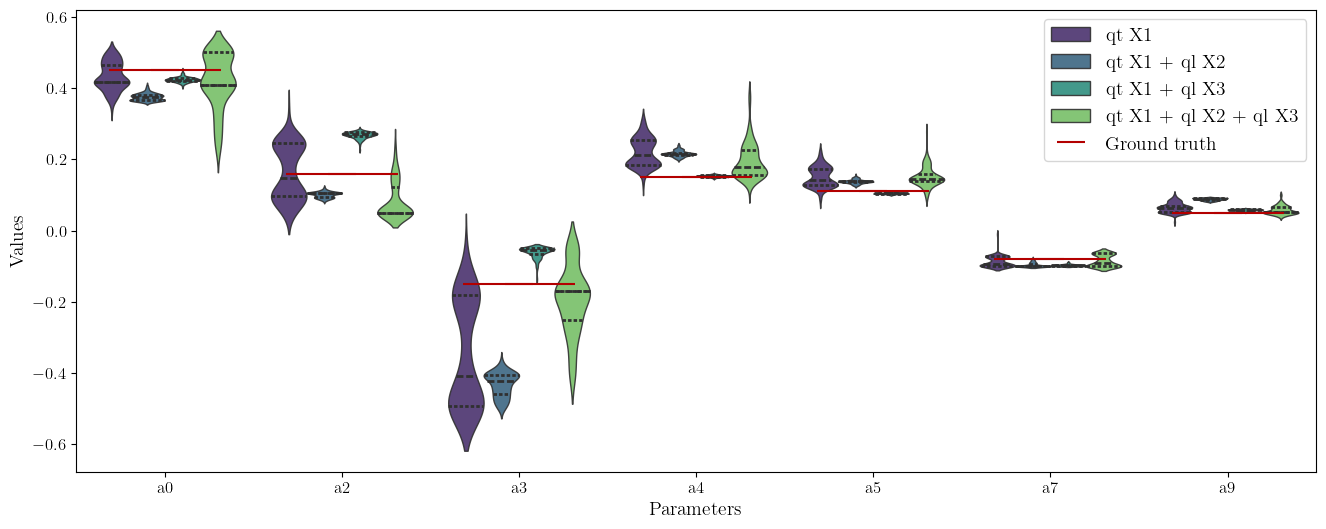

In [119]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

colors = [palette[0], palette[2], palette[4], palette[6]]

sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategie',
               palette=colors, alpha=0.9, linewidth=1, density_norm="count",
               inner="quart", inner_kws=dict(linewidth=2))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=20, markeredgewidth=1.5)

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', #label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=80, markeredgewidth=1.5)

# plt.setp(axs, ylim=(-0.01,0.61))

<AxesSubplot: xlabel='Parameters', ylabel='Values'>

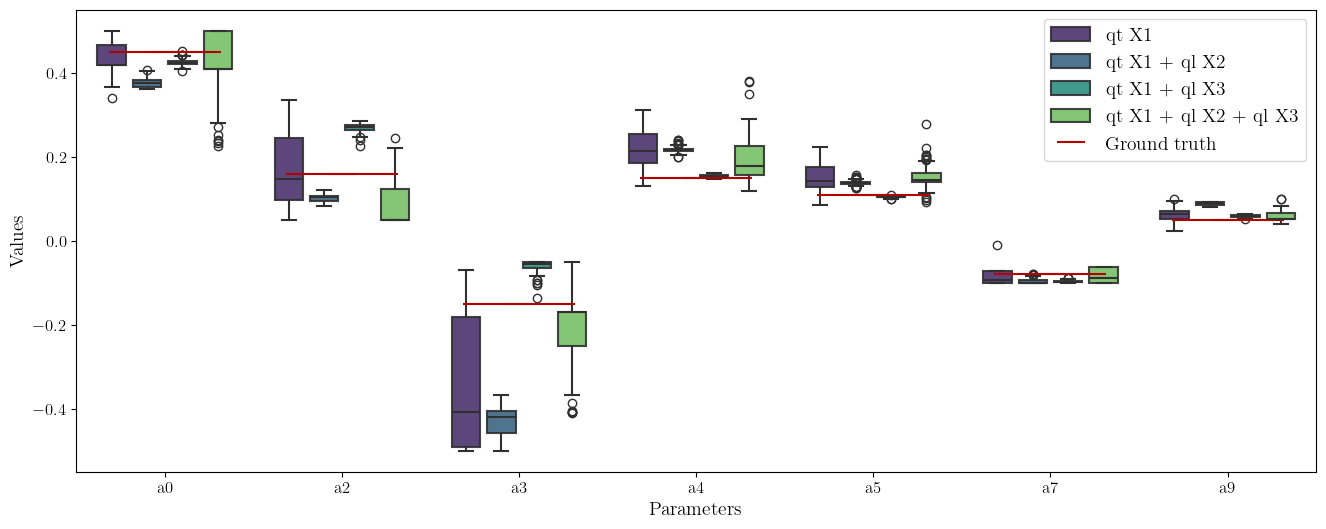

In [120]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(16,6))

colors = [palette[0], palette[2], palette[4], palette[6]]

sns.boxplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategie',
               palette=colors, linewidth=1.5, gap=0.2, boxprops=dict(alpha=.9))

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=20, markeredgewidth=1.5)

sns.pointplot(data=dfParams_ground, x='Parameters', y='Values', #label='Ground truth',
              color="#b30000", linestyle="none", marker="_", markersize=80, markeredgewidth=1.5)

# plt.setp(axs, ylim=(-0.01,0.6))